# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model


#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual.reshape(1,self.imsize)-self.img.reshape(1,self.imsize))/(self.imsize*255)

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(self.imsize)-self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [6]:
model.load_weights('CNN_MNIST.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

# Prepare Data

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#def prepare_data(X,y):
 # X = X.reshape((X.shape[0], -1))
 # X_sc = X / 255.0
 # y_cat = to_categorical(y)
 # return X_sc, y_cat

In [9]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_sc = X_train / 255.0
y_cat = to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0
y_pred_test = model.predict(np.expand_dims(X_test_sc.reshape(X_test_sc.shape[0],28,28),axis=3))
y_pred_train = model.predict(np.expand_dims(X_sc.reshape(X_sc.shape[0],28,28),axis=3))
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.9942333333333333
Test accuracy:  0.9907


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,28,1,5,10,10000)

In [12]:
subsample.shape

(1021, 784)

In [13]:
subsample_y.shape

(1021,)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],28,28),axis=3))

In [15]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.9892262487757101


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)

In [17]:
original.shape

(895, 784)

In [18]:
adversarial.shape

(126, 784)

In [19]:
adversarial_y.shape

(126,)

In [0]:
import pickle
file_ = open('subset', 'wb')
pickle.dump(original, file_)
pickle.dump(adversarial, file_)
pickle.dump(original_y, file_)
pickle.dump(adversarial_y, file_)
file_.close()


# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 100, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  0.4120764418123816 25
50  :  0.4677782823797872 25
75  :  0.4934081425501669 25
100  :  0.49396523732286485 25
125  :  0.49396523732286485 25
150  :  0.49396523732286485 25
175  :  0.49396523732286485 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


200  :  0.49396523732286485 25
225  :  0.49396523732286485 25
250  :  0.49396523732286485 25
275  :  0.49396523732286485 25
300  :  0.49396523732286485 25
325  :  0.49404245845805084 25
350  :  0.494140719181352 25
375  :  0.49440412382183296 25
400  :  0.4944460881190011 25
425  :  0.4944907745087979 25
450  :  0.4944979804780581 25
475  :  0.4945194346666948 25
500  :  0.4945722720725662 25
525  :  0.4946035972211499 25
550  :  0.4946078752270427 25
575  :  0.49461001494213924 25
600  :  0.49466280455530925 25
625  :  0.4946627152281965 25
650  :  0.4946886952271853 25
675  :  0.49476651992791965 25
700  :  0.49476651992791965 25
725  :  0.49476651992791965 25
750  :  0.49476651992791965 25
775  :  0.4948116644610952 25
800  :  0.49483023799484116 25
825  :  0.49483023799484116 25
850  :  0.49483023799484116 25
Time:  38.05701017379761  seconds
Predicted class:  [8]


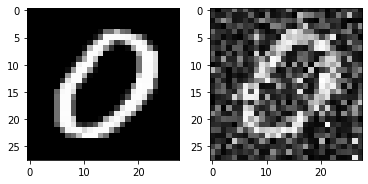

25  :  -0.3297482698177013 25
50  :  -0.17767696055000398 25
75  :  0.49311439495980836 25
100  :  0.4917606775004129 25
125  :  0.4930715524923881 25
150  :  0.4930715524923881 25
175  :  0.49329396975678724 25
200  :  0.49329396975678724 25
225  :  0.49329396975678724 25
250  :  0.4933772651944959 25
275  :  0.4933892347043132 25
300  :  0.49347206738005134 25
325  :  0.49347206738005134 25
350  :  0.4935107128450368 25
375  :  0.4935319498094588 25
400  :  0.4936704109647952 25
425  :  0.4937796319960688 25
450  :  0.4938096084741846 25
475  :  0.4938245102930183 25
500  :  0.4938984839417122 25
525  :  0.4938988892778404 25
550  :  0.4938988892778404 25
575  :  0.49395578702757054 25
600  :  0.49395595041757234 25
625  :  0.4939848741811061 25
650  :  0.4939862947146023 25
675  :  0.49400826849914536 25
700  :  0.4940368092664134 25
725  :  0.49404910981835387 25
750  :  0.49408156600288905 25
775  :  0.4940815974078032 25
800  :  0.4940815974078032 25
825  :  0.4940826263264831 25

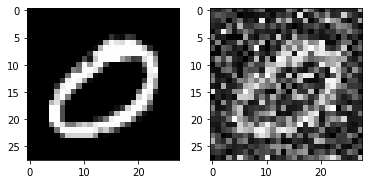

25  :  0.10704639142974766 25
50  :  0.49062683944664337 25
75  :  0.49195521720746954 25
100  :  0.49195521720746954 25
125  :  0.49196232878130863 25
150  :  0.492307150730279 25
175  :  0.4926149337968691 25
200  :  0.492725843995198 25
225  :  0.4928144039694191 25
250  :  0.49281716712737283 25
275  :  0.49281716712737283 25
300  :  0.49281716712737283 25
325  :  0.49294970377604513 25
350  :  0.49312561040334024 25
375  :  0.4932555537445144 25
400  :  0.4932555537445144 25
425  :  0.49332393563274046 25
450  :  0.49332393563274046 25
475  :  0.49338104005806155 25
500  :  0.49341598787819363 25
525  :  0.4935525550170346 25
550  :  0.49355692034967236 25
575  :  0.493558522186276 25
600  :  0.49355692034967236 25
625  :  0.4936286722772183 25
650  :  0.4936286722772183 25
675  :  0.49366335444815657 25
700  :  0.49366335444815657 25
725  :  0.493711659903097 25
750  :  0.493711659903097 25
775  :  0.49374689355599205 25
800  :  0.49374693218626015 25
825  :  0.4937821797286475 2

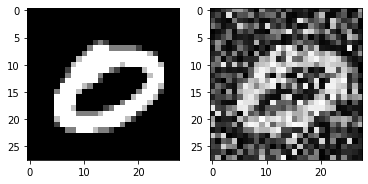

25  :  0.4778333980237257 25
50  :  0.4874866019737888 25
75  :  0.4926893711766092 25
100  :  0.49306738412515866 25
125  :  0.4934932385675195 25
150  :  0.4934932385675195 25
175  :  0.4934932385675195 25
200  :  0.4934932385675195 25
225  :  0.49369064393368917 25
250  :  0.4940843892697152 25
275  :  0.4940321784740771 25
300  :  0.49407274030532444 25
325  :  0.49403083831987155 25
350  :  0.49403083831987155 25
375  :  0.49447653708307215 25
400  :  0.49447653708307215 25
425  :  0.4944909432165985 25
450  :  0.49449818972579046 25
475  :  0.49449818972579046 25
500  :  0.49449818972579046 25
525  :  0.49456103181533667 25
550  :  0.49458840913625257 25
575  :  0.4945876938366591 25
600  :  0.49461165795998413 25
625  :  0.49461165795998413 25
650  :  0.4946315685131489 25
675  :  0.49463111170906415 25
700  :  0.4946386932206483 25
725  :  0.4946575594068369 25
750  :  0.494684925312636 25
775  :  0.49469180884287184 25
800  :  0.49469185489979156 25
Time:  35.50136089324951  s

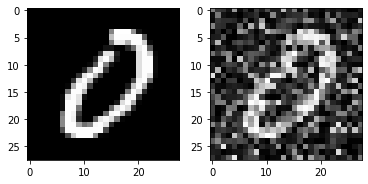

25  :  0.40398672747626035 25
50  :  0.40398672747626035 25
75  :  0.4929149428391291 25
100  :  0.4927228333839646 25
125  :  0.4928532074090468 25
150  :  0.4933683545612886 25
175  :  0.4933683545612886 25
200  :  0.49351765008048015 25
225  :  0.49370681227637003 25
250  :  0.49370681227637003 25
275  :  0.49379371539733397 25
300  :  0.49379371539733397 25
325  :  0.493820437623524 25
350  :  0.493822784031437 25
375  :  0.4938736327839033 25
400  :  0.4939964557414579 25
425  :  0.4940428955404668 25
450  :  0.4940958739912215 25
475  :  0.4940990359540556 25
500  :  0.4941625879525599 25
525  :  0.4942033984193489 25
550  :  0.494305230916455 25
575  :  0.4943109657706552 25
600  :  0.4943109320534373 25
625  :  0.49433310347963566 25
650  :  0.494412069154294 25
675  :  0.494412069154294 25
700  :  0.4944263501266527 25
725  :  0.4944610005374215 25
750  :  0.4944610005374215 25
775  :  0.4945041487659689 25
800  :  0.4945041487659689 25
825  :  0.4945202699921244 25
850  :  0.

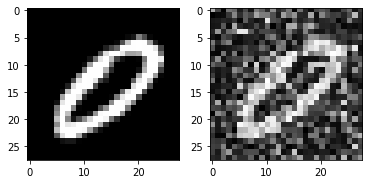

25  :  0.4834934568486515 25
50  :  0.4924869840650281 25
75  :  0.4932230223612781 25
100  :  0.4932230223612781 25
125  :  0.4932511707224537 25
150  :  0.49325962885235264 25
175  :  0.4932779839671778 25
200  :  0.4932779839671778 25
225  :  0.4932779839671778 25
250  :  0.4932779839671778 25
275  :  0.4932779839671778 25
300  :  0.4932779839671778 25
325  :  0.493613500828668 25
350  :  0.493613500828668 25
375  :  0.493613500828668 25
400  :  0.493613500828668 25
425  :  0.493613500828668 25
450  :  0.49376267523905404 25
475  :  0.49376937460275233 25
500  :  0.4937872198081778 25
525  :  0.49395647906086176 25
550  :  0.4940795871165357 25
575  :  0.4940901662972115 25
600  :  0.4940901662972115 25
625  :  0.4941644605127809 25
650  :  0.494180927713836 25
675  :  0.49422393634668066 25
700  :  0.4942869643860287 25
725  :  0.4942869643860287 25
750  :  0.494287255736496 25
775  :  0.4942872015899985 25
800  :  0.49429530913190756 25
Time:  35.111777544021606  seconds
Predicted

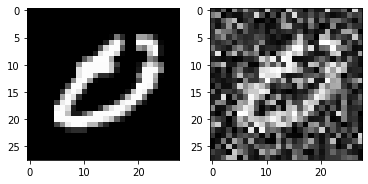

25  :  -0.23886796506666597 25
50  :  0.3614718565301039 25
75  :  0.4500074302468218 25
100  :  0.4874625326866415 25
125  :  0.492308114523259 25
150  :  0.49254951012470466 25
175  :  0.49254951012470466 25
200  :  0.49254951012470466 25
225  :  0.49269608234308293 25
250  :  0.4927327649641662 25
275  :  0.4929443026853599 25
300  :  0.49294664777239966 25
325  :  0.4929700995687502 25
350  :  0.4929700995687502 25
375  :  0.4929744127655842 25
400  :  0.49303426262898603 25
425  :  0.49311861054068057 25
450  :  0.49324136861713763 25
475  :  0.49324136861713763 25
500  :  0.4932416159678644 25
525  :  0.49341177539944947 25
550  :  0.49341379015353765 25
575  :  0.49349018013374063 25
600  :  0.4935151719773238 25
625  :  0.49364565679607514 25
650  :  0.49364565679607514 25
675  :  0.49364565679607514 25
700  :  0.49367557910068294 25
725  :  0.4936755194993816 25
750  :  0.4936755194993816 25
775  :  0.4936755194993816 25
800  :  0.4936981173876869 25
825  :  0.4936981173876869

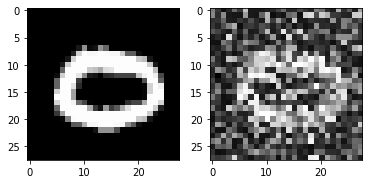

25  :  0.2983449026084477 25
50  :  0.4830178358680945 25
75  :  0.4684968239772582 25
100  :  0.4930540831079159 25
125  :  0.4937965543877771 25
150  :  0.4937324055400259 25
175  :  0.4937324055400259 25
200  :  0.4937324055400259 25
225  :  0.4937324055400259 25
250  :  0.4937324055400259 25
275  :  0.4937324055400259 25
300  :  0.4937324055400259 25
325  :  0.4937324055400259 25
350  :  0.493913546122358 25
375  :  0.493913546122358 25
400  :  0.493913546122358 25
425  :  0.493913546122358 25
450  :  0.4939797632344773 25
475  :  0.4939954653205557 25
500  :  0.4939990065486462 25
525  :  0.49407047717048863 25
550  :  0.4940850842257775 25
575  :  0.494115422156073 25
600  :  0.49411704616636304 25
625  :  0.4942170362873139 25
650  :  0.4942713524861316 25
675  :  0.49427429967182157 25
700  :  0.49427429967182157 25
725  :  0.49431030317631247 25
750  :  0.49431030317631247 25
775  :  0.49438361012561743 25
800  :  0.4943853574023534 25
825  :  0.4943853574023534 25
850  :  0.4

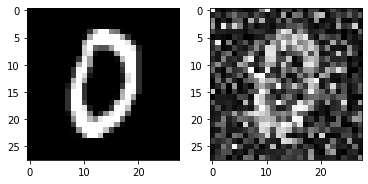

25  :  0.4267654382285526 25
50  :  0.49371672806310707 25
75  :  0.493823383585185 25
100  :  0.4938428427407908 25
125  :  0.4938675580170263 25
150  :  0.4938675580170263 25
175  :  0.4938675580170263 25
200  :  0.4938675580170263 25
225  :  0.4938675580170263 25
250  :  0.4940132765807063 25
275  :  0.4940518444917103 25
300  :  0.4940563914274034 25
325  :  0.4941558302748497 25
350  :  0.49429504327524476 25
375  :  0.49429326871284107 25
400  :  0.49435576851616414 25
425  :  0.4944059217803544 25
450  :  0.49444475443931657 25
475  :  0.4944615230564842 25
500  :  0.4945215530743076 25
525  :  0.49458329378888466 25
550  :  0.49458329378905064 25
575  :  0.49459691357875946 25
600  :  0.49459691357875946 25
625  :  0.4946263329830776 25
650  :  0.49463692660016734 25
675  :  0.49467282923669414 25
700  :  0.49467282923669414 25
725  :  0.4946795807776071 25
750  :  0.4946868568937664 25
775  :  0.494702409837699 25
800  :  0.494702409837699 25
825  :  0.49471156129606736 25
Tim

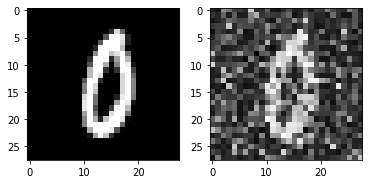

25  :  -0.24471358596665987 25
50  :  0.49233763912382394 25
75  :  0.49148062817497506 25
100  :  0.492545323352473 25
125  :  0.4930698225920215 25
150  :  0.4932122051451035 25
175  :  0.4932122051451035 25
200  :  0.4932122051451035 25
225  :  0.4932122051451035 25
250  :  0.4932122051451035 25
275  :  0.4935769993095661 25
300  :  0.49377526896640755 25
325  :  0.49383157785693327 25
350  :  0.49383157785693327 25
375  :  0.49391824708717375 25
400  :  0.49392878201238655 25
425  :  0.49401501829712285 25
450  :  0.49412583291534845 25
475  :  0.49415449677520823 25
500  :  0.49420050912306546 25
525  :  0.49422059269788654 25
550  :  0.49422065105877105 25
575  :  0.49427056597552466 25
600  :  0.49427435445999934 25
625  :  0.49427632967799356 25
650  :  0.4942835852047169 25
675  :  0.4943034296933225 25
700  :  0.49430340015368684 25
725  :  0.4943096257716966 25
750  :  0.494332250789838 25
775  :  0.494332250789838 25
800  :  0.4943460656603384 25
825  :  0.4943472799294791 

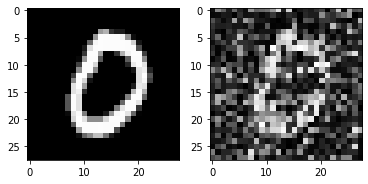

25  :  0.48909414484952046 25
50  :  0.4938097778547539 25
75  :  0.4940922460247873 25
100  :  0.4940922460247873 25
125  :  0.4940922460247873 25
150  :  0.4940922460247873 25
175  :  0.4940922460247873 25
200  :  0.4940922460247873 25
225  :  0.4940922460247873 25
250  :  0.4940922460247873 25
275  :  0.4941920573532497 25
300  :  0.4943134684809143 25
325  :  0.49430388862842656 25
350  :  0.49430388862842656 25
375  :  0.49430388862842656 25
400  :  0.49430388862842656 25
425  :  0.494434449899302 25
450  :  0.494434449899302 25
475  :  0.49455792896975864 25
500  :  0.49456851744633146 25
525  :  0.49456882929679497 25
550  :  0.49456882929679497 25
575  :  0.49456882929679497 25
600  :  0.4945779370625403 25
625  :  0.49459305065869286 25
650  :  0.49464681020098544 25
675  :  0.49467383093526124 25
700  :  0.49467383093526124 25
725  :  0.4946828853161299 25
750  :  0.4946859942610967 25
775  :  0.49475502871102855 25
800  :  0.49476198791481396 25
Time:  35.33062696456909  sec

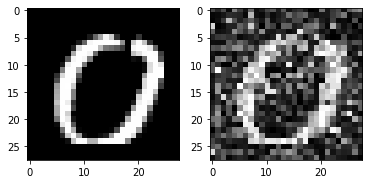

25  :  0.3445144159086624 25
50  :  0.4909494131294211 25
75  :  0.49222076745999305 25
100  :  0.4928854103627016 25
125  :  0.493229116161333 25
150  :  0.493229116161333 25
175  :  0.493229116161333 25
200  :  0.493229116161333 25
225  :  0.493229116161333 25
250  :  0.493229116161333 25
275  :  0.4933096142233485 25
300  :  0.4933531689342095 25
325  :  0.49345325869825063 25
350  :  0.4934711453379773 25
375  :  0.4935122404706802 25
400  :  0.4935314881974635 25
425  :  0.49352028557313155 25
450  :  0.49352524266797765 25
475  :  0.493674471519507 25
500  :  0.4936929119796392 25
525  :  0.4938600817272205 25
550  :  0.4938600817272205 25
575  :  0.4938755811355014 25
600  :  0.4939248172114839 25
625  :  0.49392355918630876 25
650  :  0.4940201784234956 25
675  :  0.4940201784234956 25
700  :  0.4940201784234956 25
725  :  0.4940201784234956 25
750  :  0.494074628712438 25
775  :  0.49407933535504917 25
800  :  0.4941442202538129 25
825  :  0.4941442202538129 25
Time:  36.46112

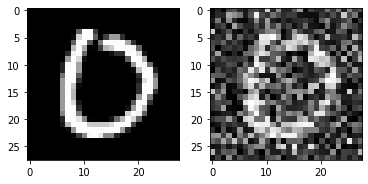

25  :  0.4952494293261284 25
50  :  0.4952494293261284 25
75  :  0.4954718537712134 25
100  :  0.4954597951265994 25
125  :  0.4954597951265994 25
150  :  0.49558733267247057 25
175  :  0.49558733267247057 25
200  :  0.49559277363380805 25
225  :  0.49559830362800916 25
250  :  0.4957403494440254 25
275  :  0.4957403494440254 25
300  :  0.4957403494440254 25
325  :  0.4957957521318995 25
350  :  0.49594548872820027 25
375  :  0.49591979381592827 25
400  :  0.49591979381592827 25
425  :  0.495934917705021 25
450  :  0.495934917705021 25
475  :  0.495934917705021 25
500  :  0.49596386610307247 25
525  :  0.49596507823464403 25
550  :  0.49596507823464403 25
575  :  0.49603257419837765 25
600  :  0.49603322381914927 25
625  :  0.4960642736472337 25
650  :  0.49606384998111636 25
675  :  0.49613531275884465 25
700  :  0.4961367701728404 25
725  :  0.49617148759581825 25
750  :  0.49619990407214126 25
775  :  0.49619990407214126 25
800  :  0.4962496904944478 25
Time:  35.62263298034668  sec

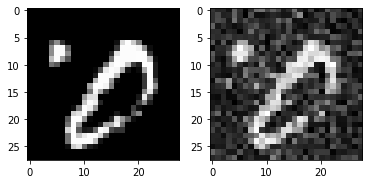

25  :  0.4948410300008102 25
50  :  0.4948410300008102 25
75  :  0.49485996986331 25
100  :  0.4948769890991601 25
125  :  0.49491885004297026 25
150  :  0.49498739812155673 25
175  :  0.4950742553735849 25
200  :  0.49507464907297716 25
225  :  0.4952710818257108 25
250  :  0.49530308504683335 25
275  :  0.49530308504683335 25
300  :  0.49530308504683335 25
325  :  0.49530308504683335 25
350  :  0.49530308504683335 25
375  :  0.49530308504683335 25
400  :  0.49530308504683335 25
425  :  0.49530308504683335 25
450  :  0.49530308504683335 25
475  :  0.49530308504683335 25
500  :  0.4953247902971457 25
525  :  0.4953263430553303 25
550  :  0.49536499972795783 25
575  :  0.4953647156815174 25
600  :  0.4953647156815174 25
625  :  0.4953647156815174 25
650  :  0.4953647156815174 25
675  :  0.4953647156815174 25
700  :  0.4953647156815174 25
725  :  0.4954050224044141 25
750  :  0.4954050224044141 25
775  :  0.49542934601093463 25
800  :  0.4954651560112668 25
Time:  35.37126135826111  seco

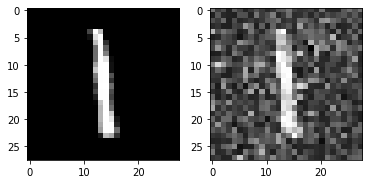

25  :  0.4948014426756432 25
50  :  0.4948014426756432 25
75  :  0.4948014426756432 25
100  :  0.4948014426756432 25
125  :  0.4948014426756432 25
150  :  0.49491095757475434 25
175  :  0.49491095757475434 25
200  :  0.49491095757475434 25
225  :  0.49500903984232053 25
250  :  0.49491113439853646 25
275  :  0.49491113439853646 25
300  :  0.4950424309306815 25
325  :  0.49501517323608113 25
350  :  0.49501517323608113 25
375  :  0.49520739562813976 25
400  :  0.49519664192303176 25
425  :  0.49519664192303176 25
450  :  0.49519664192303176 25
475  :  0.49519664192303176 25
500  :  0.49519664192303176 25
525  :  0.49519664192303176 25
550  :  0.49536440248936725 25
575  :  0.49536263888500914 25
600  :  0.49536646874288676 25
625  :  0.49545842073678786 25
650  :  0.49549225690835225 25
675  :  0.49549028310620485 25
700  :  0.49549028310620485 25
725  :  0.49549028310620485 25
750  :  0.49549560731991926 25
775  :  0.49551590457183514 25
800  :  0.4955464001532832 25
Time:  35.48376393

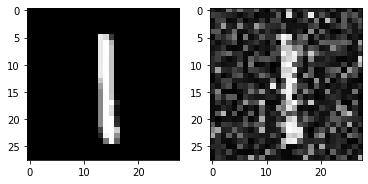

25  :  0.49364328082712894 25
50  :  0.49399156818252027 25
75  :  0.4942342783574967 25
100  :  0.4942342783574967 25
125  :  0.4943181009179168 25
150  :  0.49432816524551737 25
175  :  0.4946020944150506 25
200  :  0.49455758907041525 25
225  :  0.49455758907041525 25
250  :  0.49455758907041525 25
275  :  0.49455758907041525 25
300  :  0.49455758907041525 25
325  :  0.4945840382232417 25
350  :  0.4945840382232417 25
375  :  0.49473981411236756 25
400  :  0.4947367633371992 25
425  :  0.4947508419688586 25
450  :  0.4947508419688586 25
475  :  0.49479246612295036 25
500  :  0.49479246612295036 25
525  :  0.49479602859121574 25
550  :  0.494976512438931 25
575  :  0.4949700505957668 25
600  :  0.49503726717966967 25
625  :  0.4950736451124278 25
650  :  0.4950742816735514 25
675  :  0.4950742816735514 25
700  :  0.4950742816735514 25
725  :  0.4950840131213468 25
750  :  0.49509544996510074 25
775  :  0.4951162686615124 25
800  :  0.49512684247957145 25
Time:  35.439241886138916  se

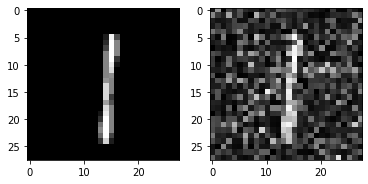

25  :  0.4949312632518054 25
50  :  0.4949312632518054 25
75  :  0.49486858710933157 25
100  :  0.49492565093517976 25
125  :  0.49492565093517976 25
150  :  0.49492565093517976 25
175  :  0.4950378694397865 25
200  :  0.4950378694397865 25
225  :  0.4950378694397865 25
250  :  0.4950378694397865 25
275  :  0.4950378694397865 25
300  :  0.4950378694397865 25
325  :  0.4950378694397865 25
350  :  0.4950378694397865 25
375  :  0.49515289874752355 25
400  :  0.4951678130796053 25
425  :  0.49527990290473917 25
450  :  0.4954462927469295 25
475  :  0.49544514677311796 25
500  :  0.49544514677311796 25
525  :  0.49544514677311796 25
550  :  0.49546471836716155 25
575  :  0.495462873320497 25
600  :  0.4955218363992393 25
625  :  0.49556716462756095 25
650  :  0.4956180482102282 25
675  :  0.4956152912628777 25
700  :  0.49565239380955406 25
725  :  0.4956484054885634 25
750  :  0.49565791778623497 25
775  :  0.4956565646912529 25
800  :  0.4956909292503622 25
Time:  35.52892446517944  secon

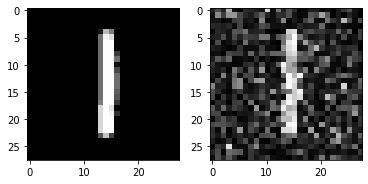

25  :  0.4949735178561049 25
50  :  0.4949735178561049 25
75  :  0.4949735178561049 25
100  :  0.4949735178561049 25
125  :  0.4949735178561049 25
150  :  0.4949735178561049 25
175  :  0.49502424934455697 25
200  :  0.49502424934455697 25
225  :  0.49502424934455697 25
250  :  0.49502424934455697 25
275  :  0.4950671682787667 25
300  :  0.49506798730236534 25
325  :  0.49507138694018504 25
350  :  0.49507138694018504 25
375  :  0.4952665372780088 25
400  :  0.4952658072444917 25
425  :  0.4952658072444917 25
450  :  0.49526752136729246 25
475  :  0.49545634028798174 25
500  :  0.49545634028798174 25
525  :  0.49545634028798174 25
550  :  0.49545634028798174 25
575  :  0.4954595174412522 25
600  :  0.49546057826583145 25
625  :  0.49546057826583145 25
650  :  0.49547513568016405 25
675  :  0.49556556925967804 25
700  :  0.49557770835349385 25
725  :  0.49561936864015915 25
750  :  0.4956475786753059 25
775  :  0.4956475786753059 25
800  :  0.4956475786753059 25
Time:  36.80047798156738 

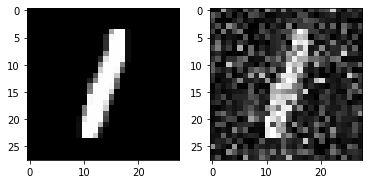

25  :  0.4951800261078912 25
50  :  0.4951800261078912 25
75  :  0.4951800261078912 25
100  :  0.4951800261078912 25
125  :  0.4951800261078912 25
150  :  0.4951800261078912 25
175  :  0.4951800261078912 25
200  :  0.4951800261078912 25
225  :  0.4951800261078912 25
250  :  0.4951800261078912 25
275  :  0.4951800261078912 25
300  :  0.4951800261078912 25
325  :  0.49543131657087813 25
350  :  0.4954380928099045 25
375  :  0.4954380928099045 25
400  :  0.4954380928099045 25
425  :  0.49544785588419016 25
450  :  0.49544785588419016 25
475  :  0.49544785588419016 25
500  :  0.4955964680469207 25
525  :  0.4955981247493464 25
550  :  0.4957243683989608 25
575  :  0.49590757507189787 25
600  :  0.4959485797902606 25
625  :  0.4959485797902606 25
650  :  0.4959485797902606 25
675  :  0.4959485797902606 25
700  :  0.4959485797902606 25
725  :  0.4959485797902606 25
750  :  0.4959513591682934 25
775  :  0.4959492063265811 25
800  :  0.4959492063265811 25
Time:  36.0485315322876  seconds
Predi

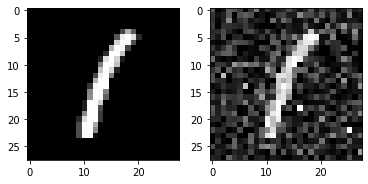

25  :  0.4940941427533452 25
50  :  0.4950174277200894 25
75  :  0.4944296133945152 25
100  :  0.49443725364423774 25
125  :  0.49446725169408445 25
150  :  0.4946594320610994 25
175  :  0.4947774848393943 25
200  :  0.4947774848393943 25
225  :  0.4947774848393943 25
250  :  0.4947774848393943 25
275  :  0.4947774848393943 25
300  :  0.4947774848393943 25
325  :  0.49483502491384734 25
350  :  0.49483502491384734 25
375  :  0.49483502491384734 25
400  :  0.49483502491384734 25
425  :  0.49483502491384734 25
450  :  0.49483502491384734 25
475  :  0.49483502491384734 25
500  :  0.4948395460075507 25
525  :  0.49486162205593115 25
550  :  0.4949467015933467 25
575  :  0.494981706031045 25
600  :  0.494981706031045 25
625  :  0.494981706031045 25
650  :  0.494981706031045 25
675  :  0.494981706031045 25
700  :  0.494981706031045 25
725  :  0.4950061494607823 25
750  :  0.49507293108893335 25
775  :  0.4951065265958522 25
800  :  0.4951067956609709 25
Time:  36.28631901741028  seconds
Pred

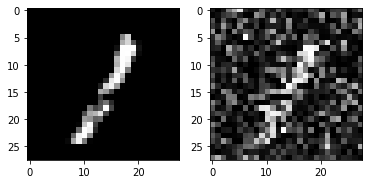

25  :  0.4946502605981719 25
50  :  0.49467192681426403 25
75  :  0.4945810959430312 25
100  :  0.4953000864190309 25
125  :  0.4953000864190309 25
150  :  0.4953000864190309 25
175  :  0.4953000864190309 25
200  :  0.4953000864190309 25
225  :  0.4953000864190309 25
250  :  0.4953000864190309 25
275  :  0.4953000864190309 25
300  :  0.4953000864190309 25
325  :  0.4953000864190309 25
350  :  0.4953000864190309 25
375  :  0.4953000864190309 25
400  :  0.4953000864190309 25
425  :  0.4953000864190309 25
450  :  0.4953000864190309 25
475  :  0.4953000864190309 25
500  :  0.4953000864190309 25
525  :  0.49539548127684585 25
550  :  0.4953846845865513 25
575  :  0.495355239910256 25
600  :  0.495355239910256 25
625  :  0.495355239910256 25
650  :  0.4954217528992028 25
675  :  0.4954142130115791 25
700  :  0.4954142130115791 25
725  :  0.4954142130115791 25
750  :  0.4955010798399969 25
775  :  0.49557096517536536 25
800  :  0.4955609359548653 25
Time:  35.90974807739258  seconds
Predicted

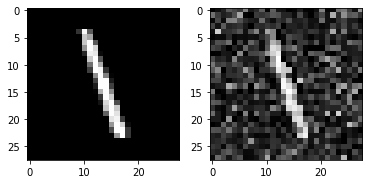

25  :  0.49515265537100267 25
50  :  0.49515265537100267 25
75  :  0.49515265537100267 25
100  :  0.49515265537100267 25
125  :  0.49532812492541006 25
150  :  0.4951972176428121 25
175  :  0.4951972176428121 25
200  :  0.4954198399195438 25
225  :  0.4956401314227838 25
250  :  0.4956401314227838 25
275  :  0.4957339444896363 25
300  :  0.4957339444896363 25
325  :  0.49598910493899784 25
350  :  0.49598910493899784 25
375  :  0.49598910493899784 25
400  :  0.49598910493899784 25
425  :  0.49598910493899784 25
450  :  0.49598910493899784 25
475  :  0.49598910493899784 25
500  :  0.4960321813210754 25
525  :  0.49606234337850136 25
550  :  0.49607122438745166 25
575  :  0.49607122438745166 25
600  :  0.49607122438745166 25
625  :  0.49611248600740443 25
650  :  0.4961122066696818 25
675  :  0.4961122066698072 25
700  :  0.4961395956412826 25
725  :  0.49613959601133045 25
750  :  0.49614013893065806 25
775  :  0.49614860873159067 25
800  :  0.4961635436803026 25
Time:  35.9554874897003

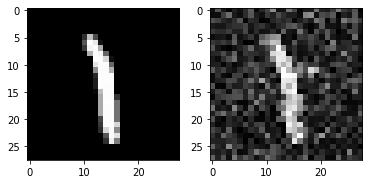

25  :  0.4941721626449065 25
50  :  0.4946372584755128 25
75  :  0.49457652772019645 25
100  :  0.49457652772019645 25
125  :  0.49457652772019645 25
150  :  0.49462009638051957 25
175  :  0.49462009638051957 25
200  :  0.494719103411202 25
225  :  0.494719103411202 25
250  :  0.494719103411202 25
275  :  0.494719103411202 25
300  :  0.4948640735794412 25
325  :  0.49482506389094616 25
350  :  0.4948860275401955 25
375  :  0.4949152328573969 25
400  :  0.49498636196829626 25
425  :  0.49498636196829626 25
450  :  0.49500438967231464 25
475  :  0.49504018939161737 25
500  :  0.4950403828233335 25
525  :  0.49507467919520587 25
550  :  0.49514314766834383 25
575  :  0.49514217783964226 25
600  :  0.49514217783964226 25
625  :  0.49514932756057695 25
650  :  0.49516105510011754 25
675  :  0.49516466769696804 25
700  :  0.49517152968045824 25
725  :  0.4951785094139232 25
750  :  0.4951785094139232 25
775  :  0.49518554913801727 25
800  :  0.4951858319979839 25
Time:  35.861735105514526  s

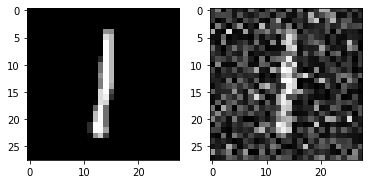

25  :  0.49503802964482774 25
50  :  0.49503802964482774 25
75  :  0.4952535868770428 25
100  :  0.4952535868770428 25
125  :  0.4952535868770428 25
150  :  0.4952535868770428 25
175  :  0.4954013569028771 25
200  :  0.49543782512944323 25
225  :  0.49560087239146466 25
250  :  0.4955751599893163 25
275  :  0.4955751599893163 25
300  :  0.4955751599893163 25
325  :  0.4955751599893163 25
350  :  0.49562063402671985 25
375  :  0.4957369779158518 25
400  :  0.49589204873281223 25
425  :  0.4958924039302139 25
450  :  0.4958924039302139 25
475  :  0.4958924039302139 25
500  :  0.4958924039302139 25
525  :  0.4959713003441264 25
550  :  0.4959713003441264 25
575  :  0.4959713003441264 25
600  :  0.4959941422704545 25
625  :  0.4960224062566098 25
650  :  0.496053800243112 25
675  :  0.496053800243112 25
700  :  0.496053800243112 25
725  :  0.49607375038521906 25
750  :  0.4960737503879305 25
775  :  0.4960809927657889 25
800  :  0.4960809927680192 25
Time:  36.11222243309021  seconds
Predi

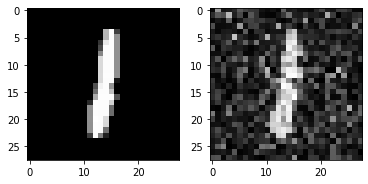

25  :  0.49474209598463154 25
50  :  0.49474209598463154 25
75  :  0.49474209598463154 25
100  :  0.4947848734599515 25
125  :  0.49480979851686396 25
150  :  0.49478603255311204 25
175  :  0.49478603255311204 25
200  :  0.49478603255311204 25
225  :  0.49478603255311204 25
250  :  0.49478603255311204 25
275  :  0.49478603255311204 25
300  :  0.4948310119834413 25
325  :  0.4948310119834413 25
350  :  0.49492933698413627 25
375  :  0.49492933698413627 25
400  :  0.49492933698413627 25
425  :  0.49492933698413627 25
450  :  0.4949629733575632 25
475  :  0.49498081943350614 25
500  :  0.4950117190587234 25
525  :  0.4950486282730173 25
550  :  0.4951167085180247 25
575  :  0.49522912280972076 25
600  :  0.49522912280972076 25
625  :  0.49522912280972076 25
650  :  0.49522912280972076 25
675  :  0.4953393864927779 25
700  :  0.4953393864927779 25
725  :  0.4953393864927779 25
750  :  0.4953503437566545 25
775  :  0.49535617618228805 25
800  :  0.49535617618228805 25
Time:  36.504221200942

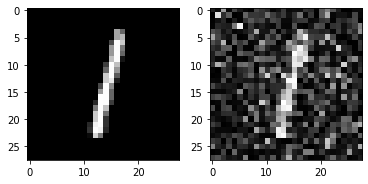

25  :  0.49491097382683 25
50  :  0.49491097382683 25
75  :  0.49491097382683 25
100  :  0.4949676556956404 25
125  :  0.4949676556956404 25
150  :  0.4949676556956404 25
175  :  0.4950783116630105 25
200  :  0.4950783116630105 25
225  :  0.4950783116630105 25
250  :  0.49511004710276413 25
275  :  0.49511004710276413 25
300  :  0.49511004710276413 25
325  :  0.49511004710276413 25
350  :  0.4953728892739858 25
375  :  0.4953728892739858 25
400  :  0.4953728892739858 25
425  :  0.4953728892739858 25
450  :  0.4953788531045992 25
475  :  0.49543274610318494 25
500  :  0.495471928396786 25
525  :  0.49547205720903836 25
550  :  0.49549025546331754 25
575  :  0.4955463038731451 25
600  :  0.49554711012461083 25
625  :  0.49556597922701356 25
650  :  0.4955910463843762 25
675  :  0.4955923880617359 25
700  :  0.4955997892574966 25
725  :  0.49562578025756926 25
750  :  0.495637084125063 25
775  :  0.49564136594719005 25
800  :  0.49564142703145064 25
Time:  35.80100131034851  seconds
Predi

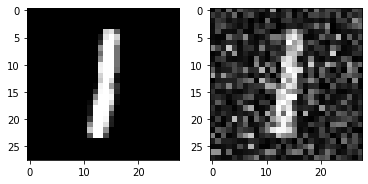

25  :  0.49513643240808514 25
50  :  0.49513643240808514 25
75  :  0.49513643240808514 25
100  :  0.49513643240808514 25
125  :  0.49540076468889865 25
150  :  0.49529256760959883 25
175  :  0.49531426677948737 25
200  :  0.49531715040572777 25
225  :  0.49531715040572777 25
250  :  0.4954692658884578 25
275  :  0.4955049925338815 25
300  :  0.495541789678961 25
325  :  0.49556344572727984 25
350  :  0.4955521691093098 25
375  :  0.49563984978935893 25
400  :  0.4956205575997415 25
425  :  0.4957522383703472 25
450  :  0.4957522383703472 25
475  :  0.49582431076160893 25
500  :  0.4958305631343487 25
525  :  0.4958377453654968 25
550  :  0.4958873280955276 25
575  :  0.4958947259531361 25
600  :  0.4959135978186501 25
625  :  0.49594807486924003 25
650  :  0.49594807486924003 25
675  :  0.4960051233177226 25
700  :  0.49601291025879396 25
725  :  0.4960432943173987 25
750  :  0.49607126820276165 25
775  :  0.49607520031316177 25
800  :  0.49610810202198163 25
Time:  35.62501883506775  

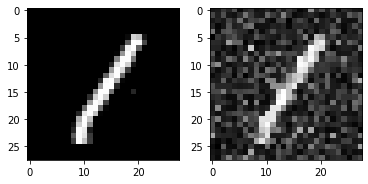

25  :  0.4937904726965834 25
50  :  0.4937904726965834 25
75  :  0.4937904726965834 25
100  :  0.4937904726965834 25
125  :  0.4937904726965834 25
150  :  0.49379877365994757 25
175  :  0.49393185459802996 25
200  :  0.4944616275400292 25
225  :  0.4944616275400292 25
250  :  0.4944616275400292 25
275  :  0.49452447459718324 25
300  :  0.4946262659468306 25
325  :  0.49464144989660125 25
350  :  0.49473710471807836 25
375  :  0.49473710471807836 25
400  :  0.49473710471807836 25
425  :  0.49480922275431705 25
450  :  0.49482340876590436 25
475  :  0.49484672943152197 25
500  :  0.4948497691453967 25
525  :  0.4948497691453967 25
550  :  0.4948505673679148 25
575  :  0.4948751195296928 25
600  :  0.4948751195296928 25
625  :  0.49487621114237773 25
650  :  0.4948839306943076 25
675  :  0.4948839306943076 25
700  :  0.4948839306943076 25
725  :  0.4948839306943076 25
750  :  0.4948853463856792 25
775  :  0.4948854504072475 25
800  :  0.494885891944261 25
Time:  35.71495699882507  seconds

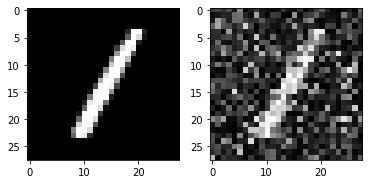

25  :  -0.4991356927073067 25
50  :  -0.39824423904227807 25
75  :  -0.4736163611004437 25
100  :  0.34799561767904585 25
125  :  0.49068403567456104 25
150  :  0.49203782120427103 25
175  :  0.49235311993881314 25
200  :  0.49235311993881314 25
225  :  0.4925876565771252 25
250  :  0.49256336198882894 25
275  :  0.49256336198882894 25
300  :  0.4926089910856737 25
325  :  0.4930198671244202 25
350  :  0.4929516729549902 25
375  :  0.49296902299767226 25
400  :  0.49296902299767226 25
425  :  0.4929913419410411 25
450  :  0.49305049186051486 25
475  :  0.4931434708913872 25
500  :  0.49321281807916684 25
525  :  0.4933454463305422 25
550  :  0.4933569533046552 25
575  :  0.4933569533046552 25
600  :  0.49338683486467166 25
625  :  0.4934081518756029 25
650  :  0.4935391628573784 25
675  :  0.49353907422135596 25
700  :  0.49356891990500823 25
725  :  0.49357195767390866 25
750  :  0.4936001378831645 25
775  :  0.49359904564541884 25
800  :  0.49365087545662223 25
825  :  0.493655698461

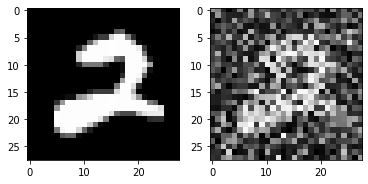

25  :  0.2783982785362209 25
50  :  0.46910155386087676 25
75  :  0.49193824852874835 25
100  :  0.4917004351218412 25
125  :  0.49198241084229444 25
150  :  0.4922543149443966 25
175  :  0.4926165425489536 25
200  :  0.4926165425489536 25
225  :  0.4927241720609828 25
250  :  0.4927241720609828 25
275  :  0.4927241720609828 25
300  :  0.4928516717466381 25
325  :  0.4928516717466381 25
350  :  0.49301679231303414 25
375  :  0.49301679231303414 25
400  :  0.4930213503621613 25
425  :  0.493057767067744 25
450  :  0.49329613337997846 25
475  :  0.49330015118413145 25
500  :  0.4933157257660938 25
525  :  0.4933157257660938 25
550  :  0.49342212475378466 25
575  :  0.4935559500883756 25
600  :  0.493553966233206 25
625  :  0.49361596741227237 25
650  :  0.4936523267954597 25
675  :  0.4936659798651254 25
700  :  0.49371772957707055 25
725  :  0.49371963968206645 25
750  :  0.49371963968206645 25
775  :  0.49371963968206645 25
800  :  0.4937468501204614 25
825  :  0.49378247680303805 25
8

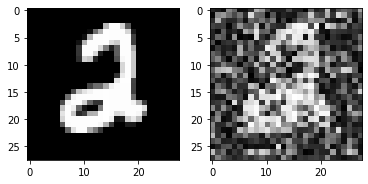

25  :  0.2530422417999065 25
50  :  0.49043281892967716 25
75  :  0.4852515205889241 25
100  :  0.49058590091131277 25
125  :  0.4914539143724266 25
150  :  0.4912403634715312 25
175  :  0.49157769683400104 25
200  :  0.4918572229601699 25
225  :  0.49192441936534975 25
250  :  0.4920484997812084 25
275  :  0.49202728215137725 25
300  :  0.49208637486114426 25
325  :  0.49223207721079243 25
350  :  0.4923382556442886 25
375  :  0.4925993342712773 25
400  :  0.4927055052120045 25
425  :  0.49288006922009886 25
450  :  0.49288006922009886 25
475  :  0.49288006922009886 25
500  :  0.49288006922009886 25
525  :  0.49298135015382727 25
550  :  0.49298296975715616 25
575  :  0.49300394107383744 25
600  :  0.4930339446673218 25
625  :  0.49306626194973346 25
650  :  0.49316153815735025 25
675  :  0.49315969395238163 25
700  :  0.4932384620863466 25
725  :  0.49325745352055084 25
750  :  0.49325874490513666 25
775  :  0.493266629653877 25
800  :  0.4933091964895862 25
825  :  0.493337200093086

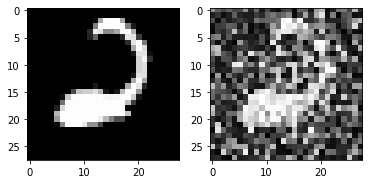

25  :  0.49416260458469413 25
50  :  0.49416260458469413 25
75  :  0.4946875278412795 25
100  :  0.4946875278412795 25
125  :  0.4946875278412795 25
150  :  0.4946875278412795 25
175  :  0.4946875278412795 25
200  :  0.4946875278412795 25
225  :  0.4946875278412795 25
250  :  0.4946875278412795 25
275  :  0.4946875278412795 25
300  :  0.4946875278412795 25
325  :  0.4946875278412795 25
350  :  0.4946875278412795 25
375  :  0.4946875278412795 25
400  :  0.4950339079379648 25
425  :  0.4949526446564588 25
450  :  0.4949526446564588 25
475  :  0.4949822213988789 25
500  :  0.49515992393900476 25
525  :  0.49515992393900476 25
550  :  0.49515992393900476 25
575  :  0.4952654300110595 25
600  :  0.4952654300110595 25
625  :  0.49529643182348104 25
650  :  0.49529643182348104 25
675  :  0.49544123091770836 25
700  :  0.4954516748093478 25
725  :  0.49547501609683203 25
750  :  0.49550651328584366 25
775  :  0.49550737440300024 25
800  :  0.4955280151130444 25
Time:  35.42097067832947  second

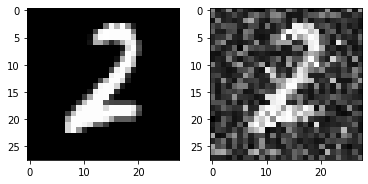

25  :  0.11761126765673524 25
50  :  0.48893189719439273 25
75  :  0.4587713905475481 25
100  :  0.48922591190338355 25
125  :  0.4929179642694882 25
150  :  0.4926004611424525 25
175  :  0.49239503168839244 25
200  :  0.49278253147996626 25
225  :  0.49278796022694993 25
250  :  0.49278254387563986 25
275  :  0.49278254387563986 25
300  :  0.49285847547976996 25
325  :  0.4931343323117451 25
350  :  0.4931343323117451 25
375  :  0.4931343323117451 25
400  :  0.4931343323117451 25
425  :  0.4931343323117451 25
450  :  0.4931343323117451 25
475  :  0.49317665206353223 25
500  :  0.49317665206353223 25
525  :  0.49317665206353223 25
550  :  0.49317665206353223 25
575  :  0.4932051667269684 25
600  :  0.4932146782577702 25
625  :  0.4932146782577702 25
650  :  0.4932146782577702 25
675  :  0.493316323893915 25
700  :  0.49346205397037435 25
725  :  0.49357939492721037 25
750  :  0.49360832569328794 25
775  :  0.4936022800496822 25
800  :  0.4936022800496822 25
825  :  0.4936299292527125 2

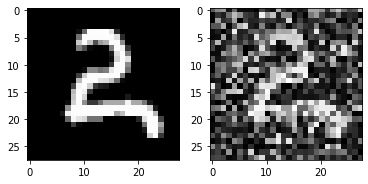

25  :  0.4941926489128734 25
50  :  0.4941926489128734 25
75  :  0.4941584184422308 25
100  :  0.4941584184422308 25
125  :  0.4941584184422308 25
150  :  0.49457400458448975 25
175  :  0.49457400458448975 25
200  :  0.49457400458448975 25
225  :  0.49457400458448975 25
250  :  0.49457400458448975 25
275  :  0.49457400458448975 25
300  :  0.4947165592697923 25
325  :  0.49478344650238903 25
350  :  0.4948697808038399 25
375  :  0.4948697808038399 25
400  :  0.4948697808038399 25
425  :  0.4948697808038399 25
450  :  0.4948697808038399 25
475  :  0.4948697808038399 25
500  :  0.4948697808038399 25
525  :  0.4948697808038399 25
550  :  0.4948697808038399 25
575  :  0.49492302777335573 25
600  :  0.49496171911033693 25
625  :  0.49496171911033693 25
650  :  0.49500056968142736 25
675  :  0.49503669797500804 25
700  :  0.49503669797500804 25
725  :  0.49508406640886615 25
750  :  0.49508409957819177 25
775  :  0.4950963042676194 25
800  :  0.4950963042676194 25
Time:  35.475602865219116  s

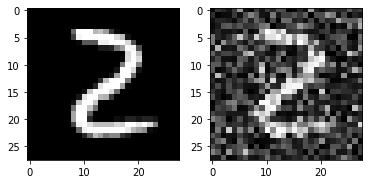

25  :  0.38917202434499026 25
50  :  0.4777251014963575 25
75  :  0.49141338850942645 25
100  :  0.49379747923420597 25
125  :  0.49379747923420597 25
150  :  0.49379747923420597 25
175  :  0.49384804466441684 25
200  :  0.49384740387872733 25
225  :  0.49384740387872733 25
250  :  0.49414840863557336 25
275  :  0.49414840863557336 25
300  :  0.49414840863557336 25
325  :  0.49414840863557336 25
350  :  0.49414840863557336 25
375  :  0.49414840863557336 25
400  :  0.49419605403017036 25
425  :  0.49427332731157436 25
450  :  0.49427332731157436 25
475  :  0.494332161988119 25
500  :  0.4944198461420779 25
525  :  0.4944253337908746 25
550  :  0.49452249323175057 25
575  :  0.4945375229318279 25
600  :  0.49456686735633704 25
625  :  0.49456680964357586 25
650  :  0.49456680964357586 25
675  :  0.4945803380168229 25
700  :  0.49458114891088883 25
725  :  0.4945878646781654 25
750  :  0.4946082711797459 25
775  :  0.49462997763413535 25
800  :  0.4946520057033559 25
825  :  0.49465279669

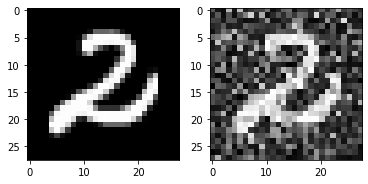

25  :  0.34158345861449724 25
50  :  0.430681248018232 25
75  :  0.49244316353137335 25
100  :  0.493215197817068 25
125  :  0.49282513928176414 25
150  :  0.49308471269093657 25
175  :  0.49308471269093657 25
200  :  0.49308471269093657 25
225  :  0.4932970005381629 25
250  :  0.4936698438881798 25
275  :  0.49367891163390326 25
300  :  0.4936814378988388 25
325  :  0.49376436877732655 25
350  :  0.4937755591787436 25
375  :  0.4938139565163966 25
400  :  0.4938389663819535 25
425  :  0.493870712207035 25
450  :  0.49391064511414257 25
475  :  0.4940381104912808 25
500  :  0.4940381104912808 25
525  :  0.49412369367314646 25
550  :  0.4941269005866541 25
575  :  0.4941348416403149 25
600  :  0.4941348416403149 25
625  :  0.4941775191710145 25
650  :  0.49420972179425837 25
675  :  0.49421405349423264 25
700  :  0.49422482323794703 25
725  :  0.49424179291784237 25
750  :  0.49424171262094946 25
775  :  0.49424171262094946 25
800  :  0.494269495446353 25
825  :  0.4942720793270148 25
8

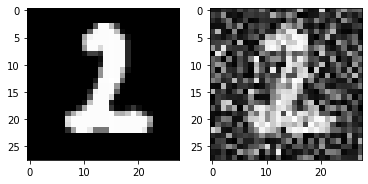

25  :  0.48186827280016953 25
50  :  0.49412554952596704 25
75  :  0.4933268039893465 25
100  :  0.49332870354890396 25
125  :  0.4933746605712633 25
150  :  0.4933808243620564 25
175  :  0.49351944129454706 25
200  :  0.49351944129454706 25
225  :  0.49351944129454706 25
250  :  0.4939662023767412 25
275  :  0.4940128823042778 25
300  :  0.4943812854509267 25
325  :  0.4943812854509267 25
350  :  0.4943812854509267 25
375  :  0.4943812854509267 25
400  :  0.4945038074201404 25
425  :  0.4945038074201404 25
450  :  0.4945038074201404 25
475  :  0.49453721174199566 25
500  :  0.49454736036729396 25
525  :  0.49464601614064246 25
550  :  0.49464601614064246 25
575  :  0.49465816458468553 25
600  :  0.49467861834910776 25
625  :  0.49468804826961105 25
650  :  0.4946899114996187 25
675  :  0.4946973562284908 25
700  :  0.4947200108132463 25
725  :  0.4947200108132463 25
750  :  0.4947292281443925 25
775  :  0.49473528571485925 25
800  :  0.4947449741885012 25
825  :  0.4947455905959073 25

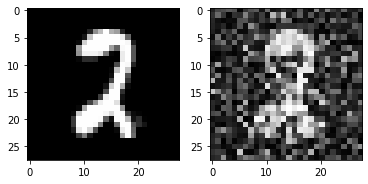

25  :  -0.04297422779136439 25
50  :  0.2994872375580182 25
75  :  0.3389725319381724 25
100  :  0.4936524250940309 25
125  :  0.49373116915133136 25
150  :  0.4938511484784649 25
175  :  0.4938069052365495 25
200  :  0.4938069052365495 25
225  :  0.4938069052365495 25
250  :  0.4938069052365495 25
275  :  0.4938069052365495 25
300  :  0.4938582236507881 25
325  :  0.4938582236507881 25
350  :  0.49401605926805314 25
375  :  0.4942789492572431 25
400  :  0.4942912159247916 25
425  :  0.4945968991270229 25
450  :  0.494613139664828 25
475  :  0.494613139664828 25
500  :  0.494613139664828 25
525  :  0.4946379773018568 25
550  :  0.49471455651646173 25
575  :  0.4947478261884931 25
600  :  0.4947841348211835 25
625  :  0.4948095640784296 25
650  :  0.49483594055527985 25
675  :  0.49485085687247204 25
700  :  0.4948848231701212 25
725  :  0.4948848403897633 25
750  :  0.49490539619285956 25
775  :  0.49490803107519143 25
800  :  0.49490803107519143 25
825  :  0.49491316575566074 25
850  

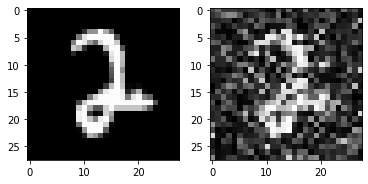

25  :  0.28258567509808485 25
50  :  0.28258567509808485 25
75  :  0.479381415532861 25
100  :  0.479381415532861 25
125  :  0.49254785124223116 25
150  :  0.49256843362659775 25
175  :  0.4931697496953813 25
200  :  0.49316925191963484 25
225  :  0.4934338743300371 25
250  :  0.4934562481440618 25
275  :  0.49367569271184597 25
300  :  0.4941580251218942 25
325  :  0.49418218674064923 25
350  :  0.49418218674064923 25
375  :  0.49418218674064923 25
400  :  0.49422080535197976 25
425  :  0.49422080535197976 25
450  :  0.49422080535197976 25
475  :  0.49422080535197976 25
500  :  0.4943099803747955 25
525  :  0.494328102814175 25
550  :  0.4943517107177895 25
575  :  0.4943783042863317 25
600  :  0.49439423457969156 25
625  :  0.49441284488662063 25
650  :  0.4945002883899088 25
675  :  0.4945831770796722 25
700  :  0.4946064838259666 25
725  :  0.49462596056016744 25
750  :  0.49462596056016744 25
775  :  0.49462596056016744 25
800  :  0.4946824924234803 25
825  :  0.49468268747909694 

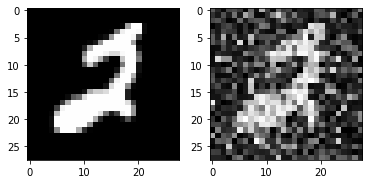

25  :  -0.22983923357939756 25
50  :  0.4780992477107216 25
75  :  0.4925383321184716 25
100  :  0.49285260497914696 25
125  :  0.49274858995339443 25
150  :  0.4930806297437654 25
175  :  0.4930806297437654 25
200  :  0.4930806297437654 25
225  :  0.4930806297437654 25
250  :  0.4930806297437654 25
275  :  0.4933908459491109 25
300  :  0.4933994254269294 25
325  :  0.4933994254269294 25
350  :  0.4933994254269294 25
375  :  0.4933994254269294 25
400  :  0.4933994254269294 25
425  :  0.4934296614636817 25
450  :  0.49370816388728817 25
475  :  0.4937167140783128 25
500  :  0.4937167140783128 25
525  :  0.4938129072833313 25
550  :  0.4938129072833313 25
575  :  0.4939515525734962 25
600  :  0.4939515525734962 25
625  :  0.4939515525734962 25
650  :  0.4940079505397338 25
675  :  0.4940240507976152 25
700  :  0.494047433372374 25
725  :  0.4940773341088295 25
750  :  0.4940918639178444 25
775  :  0.49410221659302195 25
800  :  0.49413131789790504 25
825  :  0.49416585083995196 25
850  :

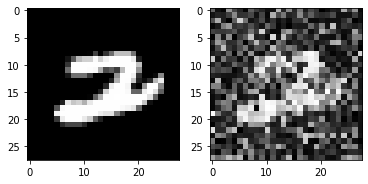

25  :  0.49516944159774645 25
50  :  0.49516944159774645 25
75  :  0.4952727409032175 25
100  :  0.4953657712255147 25
125  :  0.4953657712255147 25
150  :  0.4953657712255147 25
175  :  0.4953657712255147 25
200  :  0.4953657712255147 25
225  :  0.4953657712255147 25
250  :  0.4953657712255147 25
275  :  0.4953657712255147 25
300  :  0.4953657712255147 25
325  :  0.4953657712255147 25
350  :  0.4953657712255147 25
375  :  0.4954487898369551 25
400  :  0.49554030441187635 25
425  :  0.49557099688748957 25
450  :  0.49558095962715865 25
475  :  0.49558095962715865 25
500  :  0.49558095962715865 25
525  :  0.49558095962715865 25
550  :  0.49575360253698636 25
575  :  0.4957682333954672 25
600  :  0.4957682333954672 25
625  :  0.4958323174435222 25
650  :  0.49582686038918994 25
675  :  0.4958368792141599 25
700  :  0.495854111545297 25
725  :  0.4958969354093902 25
750  :  0.4958969354093902 25
775  :  0.49599830326232547 25
800  :  0.4959982841110729 25
Time:  34.837385177612305  second

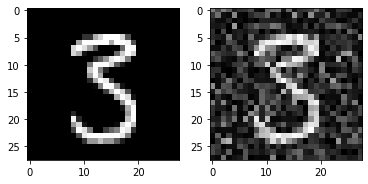

25  :  0.49394553413266473 25
50  :  0.49394553413266473 25
75  :  0.49405154002351137 25
100  :  0.4944100270844335 25
125  :  0.49446026143566607 25
150  :  0.49446026143566607 25
175  :  0.49446026143566607 25
200  :  0.49446026143566607 25
225  :  0.4947523005837846 25
250  :  0.49488727552499717 25
275  :  0.49488727552499717 25
300  :  0.49488727552499717 25
325  :  0.49488727552499717 25
350  :  0.4949469086400795 25
375  :  0.494982093247971 25
400  :  0.49517587278810166 25
425  :  0.4951766159355927 25
450  :  0.4951766159355927 25
475  :  0.4951766159355927 25
500  :  0.49522532902879235 25
525  :  0.49522532902879235 25
550  :  0.49522532902879235 25
575  :  0.49522532902879235 25
600  :  0.49522532902879235 25
625  :  0.49522532902879235 25
650  :  0.49522532902879235 25
675  :  0.49522532902879235 25
700  :  0.495261648805701 25
725  :  0.4952809521824745 25
750  :  0.4952846243250186 25
775  :  0.49534218730497814 25
800  :  0.49534228056937823 25
Time:  35.6408834457397

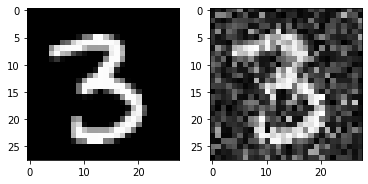

25  :  0.49456590635529246 25
50  :  0.49456590635529246 25
75  :  0.49456590635529246 25
100  :  0.49456590635529246 25
125  :  0.49456590635529246 25
150  :  0.49456590635529246 25
175  :  0.49467599639990795 25
200  :  0.49467599639990795 25
225  :  0.49471386811522156 25
250  :  0.4947393756234102 25
275  :  0.4949087148820945 25
300  :  0.4950024430304731 25
325  :  0.4950024430304731 25
350  :  0.4955584879866471 25
375  :  0.4955740136030001 25
400  :  0.4955740136030001 25
425  :  0.4955740136030001 25
450  :  0.4955740136030001 25
475  :  0.495603931356428 25
500  :  0.4956158117613398 25
525  :  0.4956158117613398 25
550  :  0.4956158117613398 25
575  :  0.4956158117613398 25
600  :  0.49563056294923513 25
625  :  0.495662875489997 25
650  :  0.49567171187307013 25
675  :  0.49567306546320766 25
700  :  0.49569882153973793 25
725  :  0.49569882153973793 25
750  :  0.4957042217770135 25
775  :  0.4957057787990303 25
800  :  0.4957075228156951 25
Time:  35.229299783706665  seco

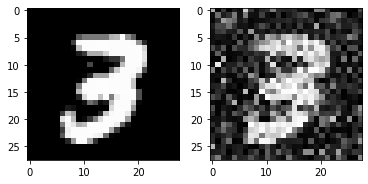

25  :  0.4896642164083843 25
50  :  0.4896642164083843 25
75  :  0.49384838144763055 25
100  :  0.4939404068659685 25
125  :  0.4941787632610883 25
150  :  0.4943144119490485 25
175  :  0.49440435710594666 25
200  :  0.49440435710594666 25
225  :  0.49446097178846343 25
250  :  0.49446097178846343 25
275  :  0.49446097178846343 25
300  :  0.4944819088688819 25
325  :  0.4944819088688819 25
350  :  0.49465402983952744 25
375  :  0.4946978949666387 25
400  :  0.49469934860855513 25
425  :  0.4947411662608391 25
450  :  0.4947411662608391 25
475  :  0.4947411662608391 25
500  :  0.4949516980649583 25
525  :  0.4949516980649583 25
550  :  0.495090910161408 25
575  :  0.4950915971172591 25
600  :  0.49511186480074043 25
625  :  0.49513818429336104 25
650  :  0.4951495229340095 25
675  :  0.4951486446228185 25
700  :  0.4951609180373987 25
725  :  0.49516738153541756 25
750  :  0.4951719968185214 25
775  :  0.49518282562054755 25
800  :  0.49519821804827174 25
Time:  34.64927792549133  secon

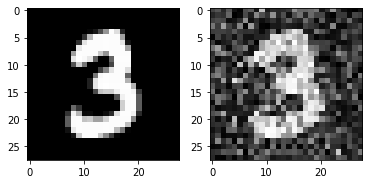

25  :  0.4725220689987301 25
50  :  0.49286141947205897 25
75  :  0.49379848930836007 25
100  :  0.49448494829846956 25
125  :  0.49448494829846956 25
150  :  0.49448494829846956 25
175  :  0.49448494829846956 25
200  :  0.49448494829846956 25
225  :  0.49448494829846956 25
250  :  0.49448494829846956 25
275  :  0.49448494829846956 25
300  :  0.49448494829846956 25
325  :  0.49448494829846956 25
350  :  0.49448494829846956 25
375  :  0.4946011287598449 25
400  :  0.4946677161584614 25
425  :  0.4946677161584614 25
450  :  0.4946677161584614 25
475  :  0.4946677161584614 25
500  :  0.4946677161584614 25
525  :  0.4946677161584614 25
550  :  0.4946677161584614 25
575  :  0.4946677161584614 25
600  :  0.4946677161584614 25
625  :  0.4946677161584614 25
650  :  0.49489191227233564 25
675  :  0.4948857338844436 25
700  :  0.49492029842296525 25
725  :  0.49492029842296525 25
750  :  0.4949749521435855 25
775  :  0.4949749521435855 25
800  :  0.4949749521435855 25
825  :  0.4949755784313315 

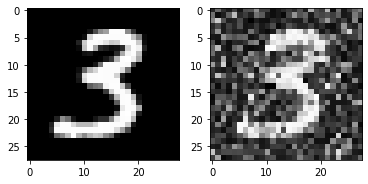

25  :  0.38156043256653965 25
50  :  0.47680692533020463 25
75  :  0.4932172427322918 25
100  :  0.4930091448416208 25
125  :  0.493278890271631 25
150  :  0.493278890271631 25
175  :  0.49354381655271473 25
200  :  0.49339790908690084 25
225  :  0.49337758920143093 25
250  :  0.49337758920143093 25
275  :  0.49337758920143093 25
300  :  0.49337758920143093 25
325  :  0.49337758920143093 25
350  :  0.49345561367518787 25
375  :  0.4936758448299457 25
400  :  0.4937383120363417 25
425  :  0.4939082670206217 25
450  :  0.4939121073538902 25
475  :  0.4939210491382853 25
500  :  0.4939216201856083 25
525  :  0.4939216201856083 25
550  :  0.4939216201856083 25
575  :  0.4939216201856083 25
600  :  0.4939216201856083 25
625  :  0.4939526523977789 25
650  :  0.4939526523977789 25
675  :  0.4939526523977789 25
700  :  0.4939692898577542 25
725  :  0.4940516101595478 25
750  :  0.4941004665940666 25
775  :  0.49409936250844516 25
800  :  0.4941152036347561 25
825  :  0.49414900593727784 25
850

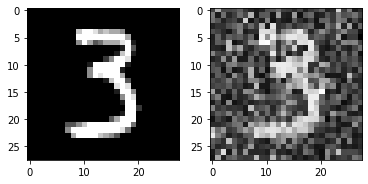

25  :  0.4930166821932969 25
50  :  0.4935847299398919 25
75  :  0.4934142505139405 25
100  :  0.4934142505139405 25
125  :  0.4934142505139405 25
150  :  0.4934142505139405 25
175  :  0.4937263287861218 25
200  :  0.4937369160532986 25
225  :  0.4937369160532986 25
250  :  0.4937369160532986 25
275  :  0.4939019496191237 25
300  :  0.4939019496191237 25
325  :  0.4939019496191237 25
350  :  0.4939019496191237 25
375  :  0.49394547838834524 25
400  :  0.494070312313485 25
425  :  0.494070312313485 25
450  :  0.494070312313485 25
475  :  0.4940946904130639 25
500  :  0.4941590792777173 25
525  :  0.49421508525147495 25
550  :  0.49423974951983324 25
575  :  0.4942556678684051 25
600  :  0.4942556678684051 25
625  :  0.49428899905804896 25
650  :  0.4943718598326598 25
675  :  0.49439394356695165 25
700  :  0.49439904715447175 25
725  :  0.49442824735860297 25
750  :  0.4944302685679379 25
775  :  0.49445076986862313 25
800  :  0.4945092357884749 25
Time:  34.59006977081299  seconds
Pred

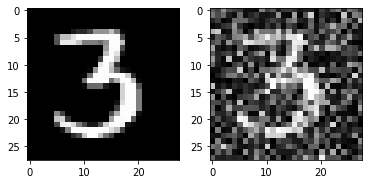

25  :  -0.4453619360222555 25
50  :  0.352347293170886 25
75  :  0.49363730590666977 25
100  :  0.49371255039784295 25
125  :  0.49371255039784295 25
150  :  0.49371255039784295 25
175  :  0.49371255039784295 25
200  :  0.49371255039784295 25
225  :  0.49371255039784295 25
250  :  0.49371255039784295 25
275  :  0.49389026408964803 25
300  :  0.4938086010117241 25
325  :  0.4938086010117241 25
350  :  0.49385250585043433 25
375  :  0.4938086010117241 25
400  :  0.4938723703481161 25
425  :  0.493874048056595 25
450  :  0.49411525263534084 25
475  :  0.49411525263534084 25
500  :  0.49418280234114387 25
525  :  0.4941855365625689 25
550  :  0.49421741678424336 25
575  :  0.4942236862419151 25
600  :  0.4942504057769459 25
625  :  0.49425173176810017 25
650  :  0.49428580293905405 25
675  :  0.4942904351862101 25
700  :  0.4942962815386849 25
725  :  0.49432972699426037 25
750  :  0.4943801310654633 25
775  :  0.4943801310654633 25
800  :  0.4944226786532246 25
825  :  0.4944433931669686 

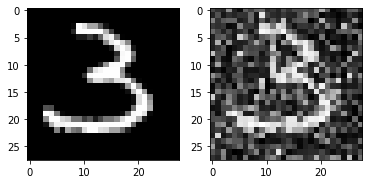

25  :  0.42248292661200026 25
50  :  0.4751871893744417 25
75  :  0.4919301641890991 25
100  :  0.49259645588968964 25
125  :  0.49332719851816575 25
150  :  0.49332719851816575 25
175  :  0.4935332460873987 25
200  :  0.49385108762676583 25
225  :  0.49396223151273444 25
250  :  0.4943367858041777 25
275  :  0.4943367858041777 25
300  :  0.4943367858041777 25
325  :  0.4943367858041777 25
350  :  0.4943367858041777 25
375  :  0.4943367858041777 25
400  :  0.4943367858041777 25
425  :  0.4944334712396925 25
450  :  0.4944334712396925 25
475  :  0.49444576897384707 25
500  :  0.49444576897384707 25
525  :  0.49444576897384707 25
550  :  0.4944533601929063 25
575  :  0.49456781982007775 25
600  :  0.49456781982007775 25
625  :  0.4945812620588558 25
650  :  0.4946248160705101 25
675  :  0.494653232806711 25
700  :  0.494653232806711 25
725  :  0.494653232806711 25
750  :  0.494653232806711 25
775  :  0.4946686072995182 25
800  :  0.49466908743467003 25
825  :  0.49467837284833543 25
850 

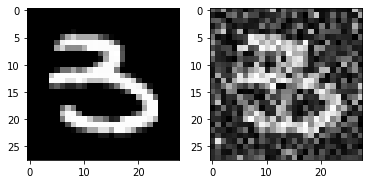

25  :  0.4950950702035604 25
50  :  0.4950950702035604 25
75  :  0.49413832891730947 25
100  :  0.4944139330447526 25
125  :  0.49454473172948954 25
150  :  0.49454473172948954 25
175  :  0.4946014126228338 25
200  :  0.4946014126228338 25
225  :  0.4946014126228338 25
250  :  0.4946014126228338 25
275  :  0.4946014126228338 25
300  :  0.4946014126228338 25
325  :  0.4946014126228338 25
350  :  0.4946014126228338 25
375  :  0.4946014126228338 25
400  :  0.4946014126228338 25
425  :  0.4946014126228338 25
450  :  0.4947004155298807 25
475  :  0.49470194342431867 25
500  :  0.49470194342431867 25
525  :  0.49470194342431867 25
550  :  0.49475783528996 25
575  :  0.49484376241735045 25
600  :  0.4947712785994208 25
625  :  0.49487870644158705 25
650  :  0.49492865532810737 25
675  :  0.4949290301576794 25
700  :  0.49497560512008004 25
725  :  0.49506236884307003 25
750  :  0.49506236884307003 25
775  :  0.49506236884307003 25
800  :  0.49506236884307003 25
Time:  35.37552237510681  secon

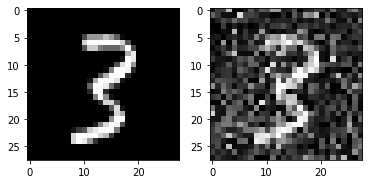

25  :  0.4843892874354597 25
50  :  0.4942435683323078 25
75  :  0.4930656341468023 25
100  :  0.4934666680674819 25
125  :  0.49350935836997356 25
150  :  0.49350935836997356 25
175  :  0.4937397003270626 25
200  :  0.4937397003270626 25
225  :  0.4937397003270626 25
250  :  0.4939718577746353 25
275  :  0.4939969216517351 25
300  :  0.4939969216517351 25
325  :  0.4940881088269456 25
350  :  0.4942099339712768 25
375  :  0.49425226452199067 25
400  :  0.4944142863308524 25
425  :  0.49442776996116555 25
450  :  0.49442776996116555 25
475  :  0.49455160767692186 25
500  :  0.4945537507403165 25
525  :  0.4945537507403165 25
550  :  0.4945537507403165 25
575  :  0.49457005061656195 25
600  :  0.4946253969066802 25
625  :  0.49466261920488175 25
650  :  0.49468991903229975 25
675  :  0.4946992129381871 25
700  :  0.49469921381249377 25
725  :  0.49474823851006905 25
750  :  0.49474823851006905 25
775  :  0.4947553158590325 25
800  :  0.49478108120384817 25
Time:  35.43956208229065  seco

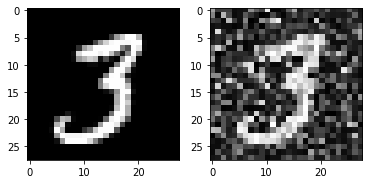

25  :  0.38441574372611254 25
50  :  0.49163136290446247 25
75  :  0.49258628407766825 25
100  :  0.4936404708145982 25
125  :  0.4930928843752117 25
150  :  0.4932801659725115 25
175  :  0.49361205548822823 25
200  :  0.49359606794165994 25
225  :  0.49389282001852947 25
250  :  0.49389282001852947 25
275  :  0.4939150125794824 25
300  :  0.4939319867187818 25
325  :  0.49394667775209555 25
350  :  0.4941932611633968 25
375  :  0.49419722122978993 25
400  :  0.4942028158257226 25
425  :  0.4942604862220468 25
450  :  0.494258927675623 25
475  :  0.494258927675623 25
500  :  0.494258927675623 25
525  :  0.49432261313149695 25
550  :  0.4943537474791373 25
575  :  0.4943537474791373 25
600  :  0.4943537474791373 25
625  :  0.4943760912675019 25
650  :  0.49440011488809454 25
675  :  0.4944327829150917 25
700  :  0.4944519494968789 25
725  :  0.4944519494968789 25
750  :  0.4944519494968789 25
775  :  0.49445315738266404 25
800  :  0.49445315738266404 25
825  :  0.49446448972347395 25
Ti

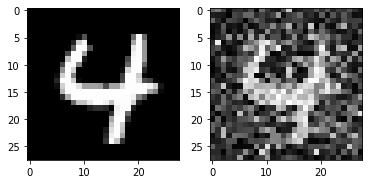

25  :  -0.00047713877172130686 25
50  :  0.4918137418146179 25
75  :  0.49289474609847833 25
100  :  0.4929290162417001 25
125  :  0.49315243298598294 25
150  :  0.49315243298598294 25
175  :  0.49315243298598294 25
200  :  0.49315243298598294 25
225  :  0.49315243298598294 25
250  :  0.49322710419308025 25
275  :  0.49322710419308025 25
300  :  0.49332067214500624 25
325  :  0.4934149405396323 25
350  :  0.4935812823308834 25
375  :  0.4935812823308834 25
400  :  0.4935812823308834 25
425  :  0.49374967792874913 25
450  :  0.49374967792874913 25
475  :  0.49374967792874913 25
500  :  0.49375385778994235 25
525  :  0.49375385778994235 25
550  :  0.4937824930819278 25
575  :  0.49385223857409977 25
600  :  0.49385257676773436 25
625  :  0.4938849453735902 25
650  :  0.4939098895708596 25
675  :  0.4939992773091446 25
700  :  0.4939992773091446 25
725  :  0.4939992773091446 25
750  :  0.4939992773091446 25
775  :  0.49400588279083735 25
800  :  0.49400588279083735 25
825  :  0.4940058827

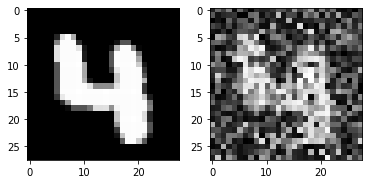

25  :  -0.0401366639644493 25
50  :  0.47051971478468513 25
75  :  0.4922742864800849 25
100  :  0.4930606945936666 25
125  :  0.4930606945936666 25
150  :  0.4930606945936666 25
175  :  0.4931702622202432 25
200  :  0.4934103545117411 25
225  :  0.4934103545117411 25
250  :  0.4934103545117411 25
275  :  0.4934103545117411 25
300  :  0.4934103545117411 25
325  :  0.4934103545117411 25
350  :  0.4934103545117411 25
375  :  0.49345801646529996 25
400  :  0.49353891451600435 25
425  :  0.4935769734598236 25
450  :  0.4935769734598236 25
475  :  0.4935853404792002 25
500  :  0.4935853404792002 25
525  :  0.4935853404792002 25
550  :  0.49369887071788454 25
575  :  0.4937045297523243 25
600  :  0.4937045297523243 25
625  :  0.4937967495991762 25
650  :  0.49383256783010976 25
675  :  0.4938564774552772 25
700  :  0.49393218522326754 25
725  :  0.49393218522326754 25
750  :  0.49393218522326754 25
775  :  0.4939811698024654 25
800  :  0.4939811698024654 25
825  :  0.4939811698024654 25
850 

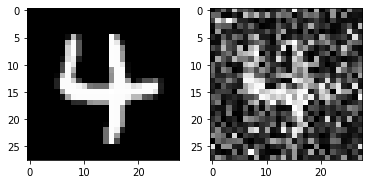

25  :  0.48026166838505985 25
50  :  0.4922582853045713 25
75  :  0.49342919371436966 25
100  :  0.49342919371436966 25
125  :  0.49342919371436966 25
150  :  0.4935445312115657 25
175  :  0.4935445312115657 25
200  :  0.4935445312115657 25
225  :  0.4935445312115657 25
250  :  0.4935445312115657 25
275  :  0.4935445312115657 25
300  :  0.49386325590123303 25
325  :  0.4940033681941652 25
350  :  0.4940033681941652 25
375  :  0.4940722876082627 25
400  :  0.4940722876082627 25
425  :  0.4943526481161696 25
450  :  0.49437010791422975 25
475  :  0.4945205331337705 25
500  :  0.4945205331337705 25
525  :  0.4945205331337705 25
550  :  0.4945205331337705 25
575  :  0.4945205331337705 25
600  :  0.49463317037433097 25
625  :  0.49463051017477266 25
650  :  0.4946446985451959 25
675  :  0.4946456532288818 25
700  :  0.4946716849720444 25
725  :  0.4947253881075913 25
750  :  0.49472836975341045 25
775  :  0.4947275579475793 25
800  :  0.4947275579475793 25
825  :  0.4947304404735975 25
Time

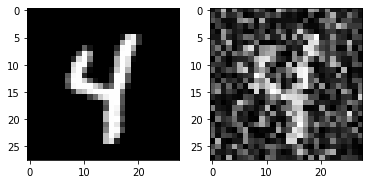

25  :  0.41891603149313433 25
50  :  0.49198212729045543 25
75  :  0.4934794226254361 25
100  :  0.4932989122917904 25
125  :  0.49358900990656196 25
150  :  0.49387356302145907 25
175  :  0.49387356302145907 25
200  :  0.49387356302145907 25
225  :  0.4940483315773196 25
250  :  0.4941177793411029 25
275  :  0.4941177793411029 25
300  :  0.4941177793411029 25
325  :  0.4941177793411029 25
350  :  0.4941177793411029 25
375  :  0.49415471815209916 25
400  :  0.4941546112898765 25
425  :  0.49418113274911807 25
450  :  0.49419622809167435 25
475  :  0.49420563396261996 25
500  :  0.49436692570859414 25
525  :  0.4943842496290564 25
550  :  0.4943833934967857 25
575  :  0.49449107119360713 25
600  :  0.49449107119360713 25
625  :  0.49449107119360713 25
650  :  0.49449107119360713 25
675  :  0.4945189956300509 25
700  :  0.49456336068166595 25
725  :  0.49456336068166595 25
750  :  0.49456336068166595 25
775  :  0.49458546876773996 25
800  :  0.49468385988420127 25
825  :  0.4946838598842

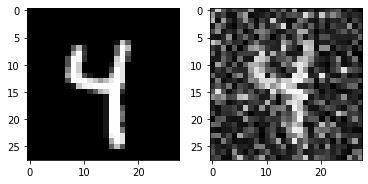

25  :  0.4951294450916218 25
50  :  0.4951294450916218 25
75  :  0.4951294450916218 25
100  :  0.4951294450916218 25
125  :  0.4951294450916218 25
150  :  0.49533125527330263 25
175  :  0.4954097329550124 25
200  :  0.4954097329550124 25
225  :  0.4954097329550124 25
250  :  0.4954097329550124 25
275  :  0.495484958980231 25
300  :  0.49544818679562563 25
325  :  0.49544818679562563 25
350  :  0.49544818679562563 25
375  :  0.49544818679562563 25
400  :  0.49544818679562563 25
425  :  0.49544818679562563 25
450  :  0.49544818679562563 25
475  :  0.49551899074520034 25
500  :  0.4955389416223521 25
525  :  0.4955405984297923 25
550  :  0.4955405984297923 25
575  :  0.49557682228332733 25
600  :  0.49558321122926213 25
625  :  0.49558321122926213 25
650  :  0.49558321122926213 25
675  :  0.49564615876599355 25
700  :  0.4957304216686457 25
725  :  0.4957304293785523 25
750  :  0.4958326604391914 25
775  :  0.4958326604391914 25
800  :  0.4958326604391914 25
Time:  35.10339093208313  seco

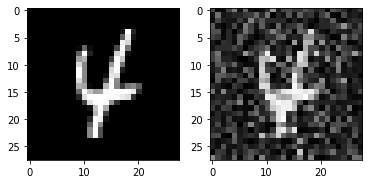

25  :  0.47527343439057723 25
50  :  0.49322178586798704 25
75  :  0.4937362012616877 25
100  :  0.4939120307020202 25
125  :  0.4939120307020202 25
150  :  0.49391407810407895 25
175  :  0.49391407810407895 25
200  :  0.49395597718196066 25
225  :  0.4940326481452521 25
250  :  0.4940326481452521 25
275  :  0.4941884929036853 25
300  :  0.4941806963539108 25
325  :  0.49418259459235303 25
350  :  0.49421148059088416 25
375  :  0.4942983255998491 25
400  :  0.49429400019248804 25
425  :  0.49434882349868864 25
450  :  0.4943456916065911 25
475  :  0.4943768649923945 25
500  :  0.4945015921877571 25
525  :  0.4945445590162998 25
550  :  0.49458745480777666 25
575  :  0.49455996548431846 25
600  :  0.4947099936238184 25
625  :  0.4947099936238184 25
650  :  0.49472446842597007 25
675  :  0.49473238298786193 25
700  :  0.4947291222628616 25
725  :  0.4947574085937472 25
750  :  0.4948036667962372 25
775  :  0.4947965654075544 25
800  :  0.4947965654075544 25
825  :  0.4948395092532351 25


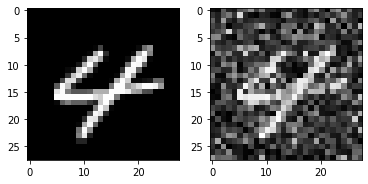

25  :  0.4542217839845113 25
50  :  0.49345061913874 25
75  :  0.49394117326846093 25
100  :  0.4944972408186807 25
125  :  0.4945649186927473 25
150  :  0.4945649186927473 25
175  :  0.4945649186927473 25
200  :  0.4945649186927473 25
225  :  0.4945649186927473 25
250  :  0.4945649186927473 25
275  :  0.49457012737817363 25
300  :  0.4945718228060882 25
325  :  0.4945778242195904 25
350  :  0.4945778242195904 25
375  :  0.4946861737180783 25
400  :  0.49468187830934907 25
425  :  0.49468187830934907 25
450  :  0.49468187830934907 25
475  :  0.49468187830934907 25
500  :  0.49472932036642336 25
525  :  0.49478244745479916 25
550  :  0.49478388498061626 25
575  :  0.49478388498061626 25
600  :  0.49481192454813067 25
625  :  0.4948106914954723 25
650  :  0.4948106914954723 25
675  :  0.4948391171809019 25
700  :  0.49484230046778815 25
725  :  0.4948826540223321 25
750  :  0.49488410114662645 25
775  :  0.49489545420713393 25
800  :  0.49490926875591545 25
825  :  0.49495608894368925 25

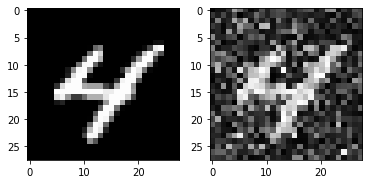

25  :  0.495163149707011 25
50  :  0.495163149707011 25
75  :  0.49520454424892507 25
100  :  0.49520454424892507 25
125  :  0.49520454424892507 25
150  :  0.49520454424892507 25
175  :  0.4953876268414635 25
200  :  0.4953635862957853 25
225  :  0.4953635862957853 25
250  :  0.4953635862957853 25
275  :  0.4953635862957853 25
300  :  0.4953869645243485 25
325  :  0.4953869645243485 25
350  :  0.4953869645243485 25
375  :  0.4953869645243485 25
400  :  0.4954606541555012 25
425  :  0.4954462439575115 25
450  :  0.4954462439575115 25
475  :  0.4955020276094383 25
500  :  0.49550281412398656 25
525  :  0.4955115658781031 25
550  :  0.495605056803515 25
575  :  0.49563625843433157 25
600  :  0.49563210681213415 25
625  :  0.4956455762935084 25
650  :  0.49568869288268336 25
675  :  0.495737227564392 25
700  :  0.49574100507022667 25
725  :  0.49574595162534 25
750  :  0.49575084938171915 25
775  :  0.4957905585881359 25
800  :  0.49580669356786233 25
Time:  34.82200360298157  seconds
Pred

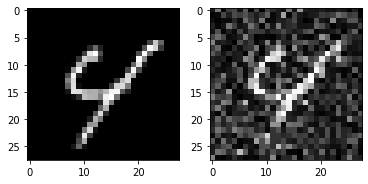

25  :  0.4751188154416106 25
50  :  0.4933517466211747 25
75  :  0.49365248172573084 25
100  :  0.49388827589842166 25
125  :  0.49388827589842166 25
150  :  0.4939237367500284 25
175  :  0.49404965787911326 25
200  :  0.49404965787911326 25
225  :  0.49404965787911326 25
250  :  0.49410415764480986 25
275  :  0.4941870205912125 25
300  :  0.4942450504367865 25
325  :  0.4944649626277408 25
350  :  0.49450760928721177 25
375  :  0.49450760928721177 25
400  :  0.4945267247570374 25
425  :  0.49451319046325926 25
450  :  0.49453669869498623 25
475  :  0.49462454268950523 25
500  :  0.49467336385351046 25
525  :  0.4947237705466195 25
550  :  0.4947456203143561 25
575  :  0.4948282588080607 25
600  :  0.4948282588080607 25
625  :  0.4948628993493727 25
650  :  0.49490098267136434 25
675  :  0.49490089330505493 25
700  :  0.49490089330505493 25
725  :  0.4949128684846676 25
750  :  0.49494246752871895 25
775  :  0.49498562377154115 25
800  :  0.49499047593597284 25
825  :  0.49504605937157

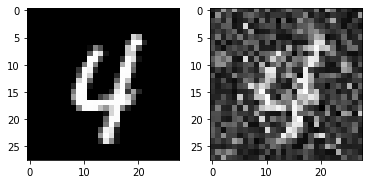

25  :  0.4011001946756512 25
50  :  0.4841360456086762 25
75  :  0.49318408640223405 25
100  :  0.49320797088374363 25
125  :  0.49342048329736327 25
150  :  0.49366677662486097 25
175  :  0.49356298090895756 25
200  :  0.49356298090895756 25
225  :  0.49356298090895756 25
250  :  0.49356298090895756 25
275  :  0.4935648956843113 25
300  :  0.49356298090895756 25
325  :  0.49356298090895756 25
350  :  0.49356298090895756 25
375  :  0.49356298090895756 25
400  :  0.49368781470728074 25
425  :  0.493730512826562 25
450  :  0.493730512826562 25
475  :  0.49383998749440533 25
500  :  0.49383998749440533 25
525  :  0.4938811059725746 25
550  :  0.4938811059725746 25
575  :  0.4938811059725746 25
600  :  0.4938811059725746 25
625  :  0.4938811059725746 25
650  :  0.4939750359711993 25
675  :  0.49411759327753096 25
700  :  0.4941159998856865 25
725  :  0.4941159998856865 25
750  :  0.4941159998856865 25
775  :  0.4941814274049234 25
800  :  0.49418160412840306 25
825  :  0.49418160412840306 

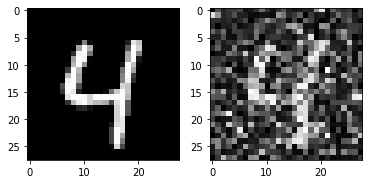

25  :  0.4922146693664506 25
50  :  0.4922146693664506 25
75  :  0.4938058741222593 25
100  :  0.4939978655862793 25
125  :  0.4941598451592068 25
150  :  0.4941598451592068 25
175  :  0.4941598451592068 25
200  :  0.4941598451592068 25
225  :  0.4941598451592068 25
250  :  0.4941598451592068 25
275  :  0.4941598451592068 25
300  :  0.4941598451592068 25
325  :  0.4941598451592068 25
350  :  0.4941598451592068 25
375  :  0.4941598451592068 25
400  :  0.4941598451592068 25
425  :  0.49418577171367056 25
450  :  0.4942969595567549 25
475  :  0.4943348821721968 25
500  :  0.4944174824913365 25
525  :  0.49441614653847915 25
550  :  0.49443973250916085 25
575  :  0.4944463966016547 25
600  :  0.4945146835276335 25
625  :  0.494528427026776 25
650  :  0.49453888080274594 25
675  :  0.49453888080274594 25
700  :  0.4945410254163888 25
725  :  0.4946145228041337 25
750  :  0.4946167403963866 25
775  :  0.4946167403963866 25
800  :  0.4946167403963866 25
Time:  34.63306427001953  seconds
Predi

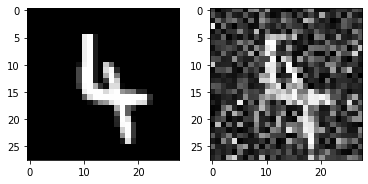

25  :  0.49283176189284467 25
50  :  0.494356923703696 25
75  :  0.4941071574133517 25
100  :  0.49472685386298787 25
125  :  0.49472685386298787 25
150  :  0.49472685386298787 25
175  :  0.49472685386298787 25
200  :  0.49472685386298787 25
225  :  0.49472685386298787 25
250  :  0.49472685386298787 25
275  :  0.49472685386298787 25
300  :  0.49475645019566633 25
325  :  0.4947905194152533 25
350  :  0.4948198806794437 25
375  :  0.4948424775877745 25
400  :  0.4948424775877745 25
425  :  0.49500773541841153 25
450  :  0.49499614697897865 25
475  :  0.49499614697897865 25
500  :  0.49499614697897865 25
525  :  0.49499614697897865 25
550  :  0.49499614697897865 25
575  :  0.495041361946351 25
600  :  0.49504186092005853 25
625  :  0.49504186092005853 25
650  :  0.4950853537391274 25
675  :  0.495123903827941 25
700  :  0.49514362062986506 25
725  :  0.4951405705590813 25
750  :  0.49515260548697493 25
775  :  0.49517649056215546 25
800  :  0.49520771438831196 25
Time:  34.43677377700806

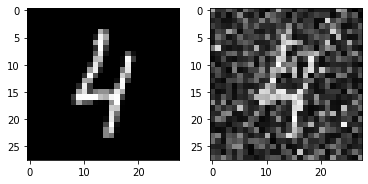

25  :  0.4949251228926254 25
50  :  0.4949251228926254 25
75  :  0.4950638301005082 25
100  :  0.4950638301005082 25
125  :  0.4950638301005082 25
150  :  0.4950638301005082 25
175  :  0.4950638301005082 25
200  :  0.4950638301005082 25
225  :  0.4950998994356887 25
250  :  0.49525241701311934 25
275  :  0.49550950279386136 25
300  :  0.4955249418423598 25
325  :  0.4955249418423598 25
350  :  0.4956057288516543 25
375  :  0.4956057288516543 25
400  :  0.49562307949375667 25
425  :  0.4956894432404383 25
450  :  0.49568809351472226 25
475  :  0.49577165295609954 25
500  :  0.49578397568578314 25
525  :  0.4957915899550096 25
550  :  0.4957945469308619 25
575  :  0.49587284580431806 25
600  :  0.49588470400225426 25
625  :  0.4958824795477896 25
650  :  0.49591630659511454 25
675  :  0.49593672304425296 25
700  :  0.49597170301012355 25
725  :  0.49597168880244125 25
750  :  0.4959879104299701 25
775  :  0.4960007154005924 25
800  :  0.49601077037405905 25
Time:  34.3519983291626  secon

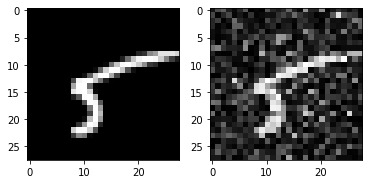

25  :  0.4935262498312651 25
50  :  0.4936850213398929 25
75  :  0.4933779871231607 25
100  :  0.49345405529391856 25
125  :  0.4938251535909393 25
150  :  0.4938251535909393 25
175  :  0.4938251535909393 25
200  :  0.4939908348620299 25
225  :  0.4939908348620299 25
250  :  0.4939908348620299 25
275  :  0.49404098319550516 25
300  :  0.49406383442349006 25
325  :  0.49406383442349006 25
350  :  0.4941905388465232 25
375  :  0.49421856421927113 25
400  :  0.49427011760832684 25
425  :  0.49427011760832684 25
450  :  0.4942728693632762 25
475  :  0.4944358404391927 25
500  :  0.4943710640238611 25
525  :  0.4943738075449952 25
550  :  0.49437408063646315 25
575  :  0.49437369261681113 25
600  :  0.49449063231730717 25
625  :  0.49449121015652986 25
650  :  0.49449121015652986 25
675  :  0.49449121015652986 25
700  :  0.49449121015652986 25
725  :  0.49449121015652986 25
750  :  0.49452148564024634 25
775  :  0.49452123751127774 25
800  :  0.4945591844187082 25
Time:  34.43800115585327  

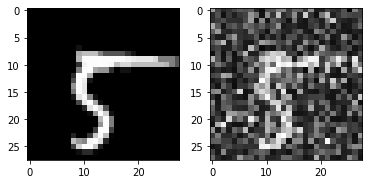

25  :  0.49501975829523975 25
50  :  0.49501975829523975 25
75  :  0.49512148762873076 25
100  :  0.4953126939401938 25
125  :  0.4953126939401938 25
150  :  0.4953126939401938 25
175  :  0.4953126939401938 25
200  :  0.4953126939401938 25
225  :  0.4953126939401938 25
250  :  0.4953126939401938 25
275  :  0.49531655739895725 25
300  :  0.4954476795136126 25
325  :  0.4955504426105251 25
350  :  0.49555045135991177 25
375  :  0.4956117624604096 25
400  :  0.49564600650854407 25
425  :  0.49568705974513183 25
450  :  0.4957116121407227 25
475  :  0.4957491021155693 25
500  :  0.4957574533086051 25
525  :  0.49577523263954676 25
550  :  0.49583966309711125 25
575  :  0.4958530935851471 25
600  :  0.4958531368617814 25
625  :  0.4958531368617814 25
650  :  0.4958531368617814 25
675  :  0.49587099987289995 25
700  :  0.49587099987289995 25
725  :  0.49588039531105654 25
750  :  0.4958974624170619 25
775  :  0.49590991513291505 25
800  :  0.4959099757815161 25
Time:  34.427305936813354  sec

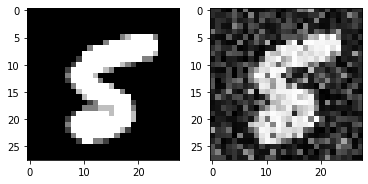

25  :  0.35498539467205287 25
50  :  0.4931414904209451 25
75  :  0.49319611139639574 25
100  :  0.49387356799954674 25
125  :  0.4937655463346418 25
150  :  0.4937655463346418 25
175  :  0.4941155441101227 25
200  :  0.4944915775055463 25
225  :  0.49443304840686103 25
250  :  0.49443304840686103 25
275  :  0.4947260357586002 25
300  :  0.49473288349094174 25
325  :  0.49473288349094174 25
350  :  0.49473288349094174 25
375  :  0.49473288349094174 25
400  :  0.49473288349094174 25
425  :  0.49473288349094174 25
450  :  0.49484269531724906 25
475  :  0.49484269531724906 25
500  :  0.49484269531724906 25
525  :  0.49484269531724906 25
550  :  0.49491777975680673 25
575  :  0.49491777975680673 25
600  :  0.4949381410829312 25
625  :  0.4949414213416003 25
650  :  0.4949916002434795 25
675  :  0.49499613395966036 25
700  :  0.49499830673436007 25
725  :  0.49500626776042733 25
750  :  0.4950106008041109 25
775  :  0.4950106008041109 25
800  :  0.4950287345909433 25
825  :  0.4950287346741

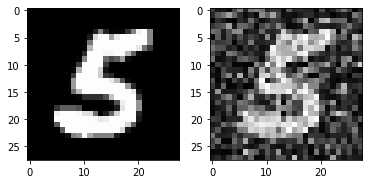

25  :  0.4022160714929243 25
50  :  0.4926259366163796 25
75  :  0.49402108071475526 25
100  :  0.49402108071475526 25
125  :  0.49402561852433663 25
150  :  0.49402438570556395 25
175  :  0.49402438570556395 25
200  :  0.49402438570556395 25
225  :  0.49402438570556395 25
250  :  0.4943100042340964 25
275  :  0.4943721790030639 25
300  :  0.4943721790030639 25
325  :  0.4943721790030639 25
350  :  0.4943721790030639 25
375  :  0.4943721790030639 25
400  :  0.4944546757702096 25
425  :  0.4945423099662894 25
450  :  0.49458180281890773 25
475  :  0.49458180281890773 25
500  :  0.4946164133310137 25
525  :  0.49463021040790445 25
550  :  0.49463021040790445 25
575  :  0.49468019166574173 25
600  :  0.4947271802390412 25
625  :  0.4947670439809831 25
650  :  0.49479160354968144 25
675  :  0.4948235743206961 25
700  :  0.4949096627199156 25
725  :  0.49495377415830744 25
750  :  0.4949825191570844 25
775  :  0.4949830671772187 25
800  :  0.4949830671772187 25
825  :  0.494998581148898 25


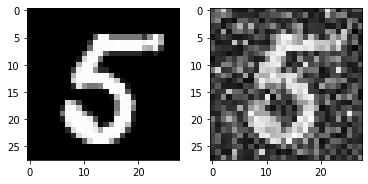

25  :  0.4925842362689999 25
50  :  0.4944367375638154 25
75  :  0.49459874659929043 25
100  :  0.49459874659929043 25
125  :  0.49468644664798456 25
150  :  0.4948801486836321 25
175  :  0.4948801486836321 25
200  :  0.4948801486836321 25
225  :  0.4948801486836321 25
250  :  0.4948801486836321 25
275  :  0.4948801486836321 25
300  :  0.4948801486836321 25
325  :  0.4948801486836321 25
350  :  0.4948801486836321 25
375  :  0.4948801486836321 25
400  :  0.4948801486836321 25
425  :  0.4948801486836321 25
450  :  0.4948801486836321 25
475  :  0.4948801486836321 25
500  :  0.4948801486836321 25
525  :  0.4948801486836321 25
550  :  0.4948801486836321 25
575  :  0.4948801486836321 25
600  :  0.4948801486836321 25
625  :  0.4949303020687014 25
650  :  0.4949229253586886 25
675  :  0.4949229253586886 25
700  :  0.4949229253586886 25
725  :  0.49509409225873546 25
750  :  0.49509409225873546 25
775  :  0.4951236664555615 25
800  :  0.4952559186905966 25
Time:  34.16482090950012  seconds
Pred

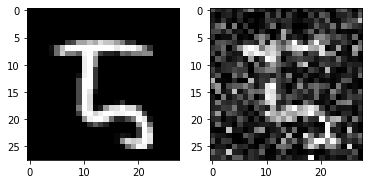

25  :  0.4951355327445041 25
50  :  0.4954489724891305 25
75  :  0.49576367043641284 25
100  :  0.49576367043641284 25
125  :  0.49576367043641284 25
150  :  0.49576367043641284 25
175  :  0.49576367043641284 25
200  :  0.49576367043641284 25
225  :  0.49576367043641284 25
250  :  0.49576367043641284 25
275  :  0.49576367043641284 25
300  :  0.49576367043641284 25
325  :  0.4958887250932002 25
350  :  0.49594899500739625 25
375  :  0.49594205044151407 25
400  :  0.4959718230782994 25
425  :  0.4959720682105012 25
450  :  0.4960021662104481 25
475  :  0.4960022258500316 25
500  :  0.4960095615446636 25
525  :  0.4960105282633743 25
550  :  0.49605034804288917 25
575  :  0.49605090314611266 25
600  :  0.496074484876178 25
625  :  0.4961398180532211 25
650  :  0.4961582134523735 25
675  :  0.4961581838912116 25
700  :  0.4962135042576309 25
725  :  0.4962135042576309 25
750  :  0.49623227036622186 25
775  :  0.49623987637551426 25
800  :  0.49628841463516477 25
Time:  34.44893169403076  s

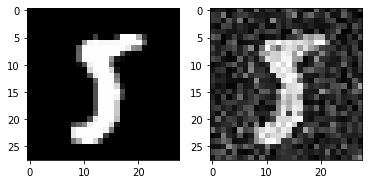

25  :  0.4950705505360789 25
50  :  0.4950705505360789 25
75  :  0.4950705505360789 25
100  :  0.4950705505360789 25
125  :  0.4950705505360789 25
150  :  0.4950705505360789 25
175  :  0.4950705505360789 25
200  :  0.49509143474282186 25
225  :  0.49517447573732576 25
250  :  0.4951054415954563 25
275  :  0.495537524706788 25
300  :  0.495537524706788 25
325  :  0.495537524706788 25
350  :  0.495537524706788 25
375  :  0.495537524706788 25
400  :  0.495537524706788 25
425  :  0.495537524706788 25
450  :  0.495537524706788 25
475  :  0.495537524706788 25
500  :  0.49554952856630036 25
525  :  0.49563787713595114 25
550  :  0.4956677383028042 25
575  :  0.4956956295094336 25
600  :  0.49572540595905956 25
625  :  0.4957243836266177 25
650  :  0.49574921238705316 25
675  :  0.4957959366971699 25
700  :  0.49581778666599435 25
725  :  0.4958648245038419 25
750  :  0.4958648017619651 25
775  :  0.4958660499140029 25
800  :  0.4958847820075992 25
Time:  34.54682540893555  seconds
Predicted c

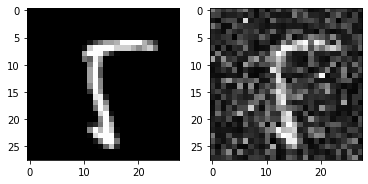

25  :  0.46510954474334343 25
50  :  0.49212010520308347 25
75  :  0.49339866466569593 25
100  :  0.4935798068838032 25
125  :  0.4935798068838032 25
150  :  0.49387031622997657 25
175  :  0.4940155541723301 25
200  :  0.494389324389503 25
225  :  0.4944271631229432 25
250  :  0.4944271631229432 25
275  :  0.4944271631229432 25
300  :  0.4944271631229432 25
325  :  0.4944271631229432 25
350  :  0.4944271631229432 25
375  :  0.4945109317478572 25
400  :  0.494595332527534 25
425  :  0.494595332527534 25
450  :  0.494595332527534 25
475  :  0.4946493122927143 25
500  :  0.4946741103691127 25
525  :  0.4948004227730023 25
550  :  0.4948101951288187 25
575  :  0.4948101951288187 25
600  :  0.49483043611003874 25
625  :  0.4948737008941272 25
650  :  0.4948758587589656 25
675  :  0.4948758587589656 25
700  :  0.4948968901894751 25
725  :  0.49489689291987704 25
750  :  0.49490783232501095 25
775  :  0.4949403313093897 25
800  :  0.4949556625007118 25
825  :  0.4949669220761305 25
Time:  35.

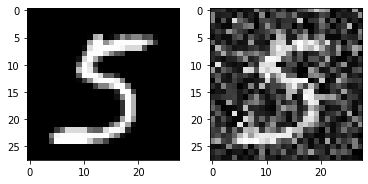

25  :  0.49496876912539955 25
50  :  0.49496876912539955 25
75  :  0.49448656961914295 25
100  :  0.494630167065622 25
125  :  0.4947314087898169 25
150  :  0.4947314087898169 25
175  :  0.4947314087898169 25
200  :  0.49479430941708147 25
225  :  0.4947923747737566 25
250  :  0.49480824699243464 25
275  :  0.49480948006013065 25
300  :  0.49480948006013065 25
325  :  0.49484289864628866 25
350  :  0.4948540191117348 25
375  :  0.4949875795040559 25
400  :  0.4950233390215434 25
425  :  0.4951651883400087 25
450  :  0.49516052343622813 25
475  :  0.49516052343622813 25
500  :  0.49516052343622813 25
525  :  0.4951734271873912 25
550  :  0.49523013408810074 25
575  :  0.4952534685372023 25
600  :  0.4952700552686249 25
625  :  0.49529081865552244 25
650  :  0.4953577376295001 25
675  :  0.4953577376295001 25
700  :  0.49539125424639374 25
725  :  0.49543366565871766 25
750  :  0.49544655804473064 25
775  :  0.4955008731038345 25
800  :  0.4955528730051949 25
Time:  34.24006772041321  se

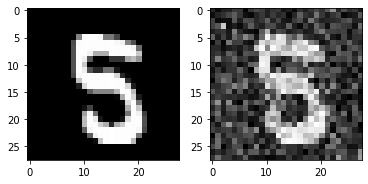

25  :  0.4850219735852142 25
50  :  0.49325945121331743 25
75  :  0.49428644838928054 25
100  :  0.4943195381127634 25
125  :  0.4943195381127634 25
150  :  0.4943195381127634 25
175  :  0.4943195381127634 25
200  :  0.4943195381127634 25
225  :  0.4943195381127634 25
250  :  0.4943195381127634 25
275  :  0.4943195381127634 25
300  :  0.49444315879577966 25
325  :  0.4944628648327756 25
350  :  0.49453403302745313 25
375  :  0.49453403302745313 25
400  :  0.49453403302745313 25
425  :  0.49463128708279636 25
450  :  0.49463128708279636 25
475  :  0.4946559776583563 25
500  :  0.4946960899059089 25
525  :  0.49469916750668974 25
550  :  0.49470181513140715 25
575  :  0.49470248629702596 25
600  :  0.4947252886913777 25
625  :  0.4947413631312603 25
650  :  0.494741453249575 25
675  :  0.49475420911109785 25
700  :  0.49475420911109785 25
725  :  0.49477933773256527 25
750  :  0.49481059680316375 25
775  :  0.49481059680316375 25
800  :  0.4948563620441936 25
Time:  34.3087522983551  sec

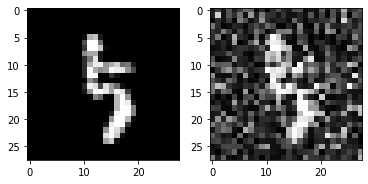

25  :  0.49476186538852185 25
50  :  0.49476186538852185 25
75  :  0.49476186538852185 25
100  :  0.49476186538852185 25
125  :  0.49476186538852185 25
150  :  0.495018844614898 25
175  :  0.4952031737085833 25
200  :  0.4952604154592246 25
225  :  0.4952604154592246 25
250  :  0.4952604154592246 25
275  :  0.4952604154592246 25
300  :  0.4952604154592246 25
325  :  0.4952604154592246 25
350  :  0.4952604154592246 25
375  :  0.4953110073795447 25
400  :  0.4953121383345144 25
425  :  0.4953121383345144 25
450  :  0.49531277539695 25
475  :  0.49535788133116043 25
500  :  0.49536161998852474 25
525  :  0.4953650517778809 25
550  :  0.4954174943355051 25
575  :  0.4954238768680688 25
600  :  0.4954584746297913 25
625  :  0.49549127039901203 25
650  :  0.4955188568311992 25
675  :  0.49557711160722345 25
700  :  0.4955765829503383 25
725  :  0.49560625681420517 25
750  :  0.4956367986338545 25
775  :  0.4956857320669758 25
800  :  0.4956857320669758 25
Time:  34.37611627578735  seconds
Pr

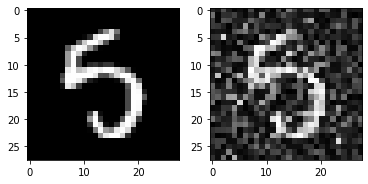

25  :  0.49167563660855007 25
50  :  0.49224434603414163 25
75  :  0.49369341240405656 25
100  :  0.4940221829493752 25
125  :  0.4943363203254819 25
150  :  0.4943363203254819 25
175  :  0.4943363203254819 25
200  :  0.4943363203254819 25
225  :  0.4943363203254819 25
250  :  0.4943363203254819 25
275  :  0.4945432358573854 25
300  :  0.49446825538792516 25
325  :  0.49447604343909785 25
350  :  0.4947518542315229 25
375  :  0.4947464306102208 25
400  :  0.4947464306102208 25
425  :  0.4947772658461483 25
450  :  0.4949297302008652 25
475  :  0.4949602847878218 25
500  :  0.4950926550192058 25
525  :  0.49520026554693125 25
550  :  0.4951944719429877 25
575  :  0.4952228021063826 25
600  :  0.495225714261243 25
625  :  0.4952683387940642 25
650  :  0.49529202675567874 25
675  :  0.49535299092812834 25
700  :  0.49535299092812834 25
725  :  0.4953654193117735 25
750  :  0.49536446732817946 25
775  :  0.4953716678704899 25
800  :  0.49539788121900274 25
Time:  35.4891254901886  seconds


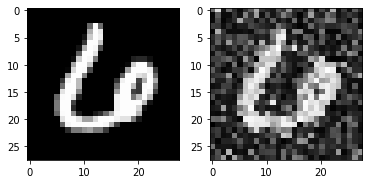

25  :  -0.21968797847469765 25
50  :  0.27073333155713 25
75  :  0.48338044714381034 25
100  :  0.4926826894648966 25
125  :  0.493306895517997 25
150  :  0.49326090880347895 25
175  :  0.4935230272892954 25
200  :  0.4935230272892954 25
225  :  0.4935230272892954 25
250  :  0.4935230272892954 25
275  :  0.4935230272892954 25
300  :  0.4939225115203554 25
325  :  0.4939225115203554 25
350  :  0.4940138802634159 25
375  :  0.49403026003863776 25
400  :  0.49403026003863776 25
425  :  0.4940727718369777 25
450  :  0.4941577757032637 25
475  :  0.49415784361349013 25
500  :  0.49415784361349013 25
525  :  0.49415784361349013 25
550  :  0.494194379932122 25
575  :  0.4942285143021825 25
600  :  0.4942906827066045 25
625  :  0.4943010133915452 25
650  :  0.49431411697132543 25
675  :  0.49431420511595286 25
700  :  0.4943578589040335 25
725  :  0.4943592901112838 25
750  :  0.4943592901112838 25
775  :  0.494382982812939 25
800  :  0.49441094592537754 25
825  :  0.49442636081571073 25
850  

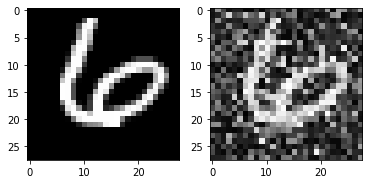

25  :  0.3524556757513776 25
50  :  0.4937372856693523 25
75  :  0.48901788499351956 25
100  :  0.4924033228820299 25
125  :  0.49304025277068725 25
150  :  0.49304025277068725 25
175  :  0.49304025277068725 25
200  :  0.49304025277068725 25
225  :  0.49304025277068725 25
250  :  0.4932667479642515 25
275  :  0.4932667479642515 25
300  :  0.4932667479642515 25
325  :  0.4932667479642515 25
350  :  0.4932667479642515 25
375  :  0.4932667479642515 25
400  :  0.4933050518740731 25
425  :  0.49353193676534 25
450  :  0.49353193676534 25
475  :  0.49353193676534 25
500  :  0.4936832802463378 25
525  :  0.4936832802463378 25
550  :  0.4936832802463378 25
575  :  0.4936832802463378 25
600  :  0.493730668827387 25
625  :  0.49382864211077665 25
650  :  0.4938320048819192 25
675  :  0.4938320048819192 25
700  :  0.4938559450673082 25
725  :  0.4938966828122146 25
750  :  0.4939296557646241 25
775  :  0.493956557120069 25
800  :  0.4939984158158123 25
825  :  0.49400283330650957 25
Time:  35.320

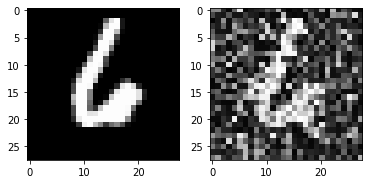

25  :  0.4920880236608306 25
50  :  0.49380367983709006 25
75  :  0.49431863476911425 25
100  :  0.4944617985386193 25
125  :  0.4944617985386193 25
150  :  0.4944617985386193 25
175  :  0.4944617985386193 25
200  :  0.4944800205574047 25
225  :  0.4944800205574047 25
250  :  0.49453432959368904 25
275  :  0.49453718334151514 25
300  :  0.49453718334151514 25
325  :  0.49453718334151514 25
350  :  0.49457005444039864 25
375  :  0.49463252469061736 25
400  :  0.49466911928496793 25
425  :  0.4947005445089898 25
450  :  0.4947005445089898 25
475  :  0.4947573104165422 25
500  :  0.49484868849706665 25
525  :  0.49486098786538796 25
550  :  0.4949448811491716 25
575  :  0.4949470846996828 25
600  :  0.4949470846996828 25
625  :  0.4949601820269402 25
650  :  0.4949606137009945 25
675  :  0.49499053834529017 25
700  :  0.4950012370701496 25
725  :  0.49502038392359476 25
750  :  0.49502505903228966 25
775  :  0.49505089087726994 25
800  :  0.49505089087726994 25
Time:  34.3310272693634  se

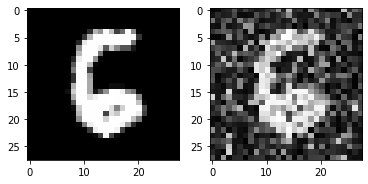

25  :  0.4675860150900497 25
50  :  0.4903378707763721 25
75  :  0.4932954370978887 25
100  :  0.49322565779276967 25
125  :  0.49305718575915763 25
150  :  0.49295757683820596 25
175  :  0.4929594670488024 25
200  :  0.4933749128735734 25
225  :  0.493454258868986 25
250  :  0.4935095622672347 25
275  :  0.49350066878615795 25
300  :  0.49350066878615795 25
325  :  0.4936102918717299 25
350  :  0.4936102918717299 25
375  :  0.49371756578588283 25
400  :  0.49385289855873754 25
425  :  0.49385289855873754 25
450  :  0.49385289855873754 25
475  :  0.493932634378895 25
500  :  0.493932634378895 25
525  :  0.493932634378895 25
550  :  0.493987825936738 25
575  :  0.4939925855537237 25
600  :  0.4939925855537237 25
625  :  0.49400120813933995 25
650  :  0.49412674120008127 25
675  :  0.49412674120008127 25
700  :  0.4941649445418456 25
725  :  0.49419365469352733 25
750  :  0.4942544175617175 25
775  :  0.4942544175617175 25
800  :  0.4942544175617175 25
825  :  0.4942869246952511 25
Time:

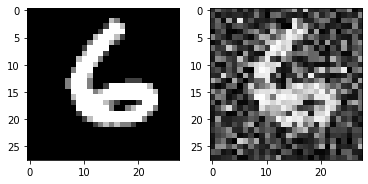

25  :  0.4935477665551563 25
50  :  0.4935477665551563 25
75  :  0.4937545111834884 25
100  :  0.4937545111834884 25
125  :  0.4942680596913847 25
150  :  0.49429731452643405 25
175  :  0.4940260253896581 25
200  :  0.4938383716907821 25
225  :  0.49432702149479396 25
250  :  0.49432702149479396 25
275  :  0.4943902903181977 25
300  :  0.4943902903181977 25
325  :  0.4943902903181977 25
350  :  0.4943902903181977 25
375  :  0.4943902903181977 25
400  :  0.4943902903181977 25
425  :  0.4943902903181977 25
450  :  0.49441407106647006 25
475  :  0.49441407106647006 25
500  :  0.49441407106647006 25
525  :  0.49441407106647006 25
550  :  0.49441407106647006 25
575  :  0.49441407106647006 25
600  :  0.494623627732156 25
625  :  0.494625079732344 25
650  :  0.494625079732344 25
675  :  0.494642108954233 25
700  :  0.494629353296035 25
725  :  0.49477894579082377 25
750  :  0.49481864141360177 25
775  :  0.4948230955922053 25
800  :  0.4948230955922053 25
Time:  33.917667627334595  seconds
Pr

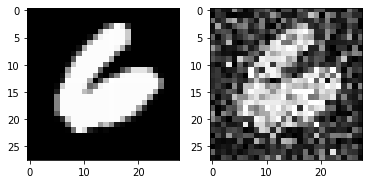

25  :  0.494867544648117 25
50  :  0.494867544648117 25
75  :  0.494867544648117 25
100  :  0.494867544648117 25
125  :  0.494867544648117 25
150  :  0.494867544648117 25
175  :  0.494867544648117 25
200  :  0.494867544648117 25
225  :  0.494867544648117 25
250  :  0.494867544648117 25
275  :  0.494867544648117 25
300  :  0.4948949516566594 25
325  :  0.4948949516566594 25
350  :  0.4948949516566594 25
375  :  0.49489620541187646 25
400  :  0.4949554689618159 25
425  :  0.4949884369521485 25
450  :  0.4952093406287181 25
475  :  0.49527690497213256 25
500  :  0.4952874675090191 25
525  :  0.4952874675090191 25
550  :  0.49529113925454865 25
575  :  0.49529081964236427 25
600  :  0.4953683347829851 25
625  :  0.49540114498721866 25
650  :  0.4954553162725588 25
675  :  0.4954495447683501 25
700  :  0.49548624386403 25
725  :  0.49552865093312665 25
750  :  0.49553015927904015 25
775  :  0.49553015927904015 25
800  :  0.49553015927904015 25
Time:  34.13156700134277  seconds
Predicted cla

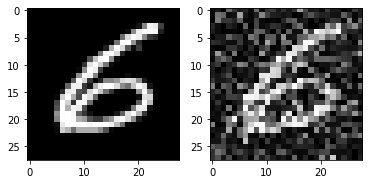

25  :  0.4920168351430629 25
50  :  0.49389319797545256 25
75  :  0.49458479986662146 25
100  :  0.49458479986662146 25
125  :  0.49458479986662146 25
150  :  0.49479183651812636 25
175  :  0.49484595867813186 25
200  :  0.4949877765787445 25
225  :  0.49484595867813186 25
250  :  0.4950615080328256 25
275  :  0.49507250381220813 25
300  :  0.49507250381220813 25
325  :  0.49507250381220813 25
350  :  0.49531389850850677 25
375  :  0.49531389850850677 25
400  :  0.49531389850850677 25
425  :  0.49531389850850677 25
450  :  0.49531389850850677 25
475  :  0.49531389850850677 25
500  :  0.4953385017136264 25
525  :  0.4953385147044116 25
550  :  0.49539801341589024 25
575  :  0.49539801341589024 25
600  :  0.49539801341589024 25
625  :  0.4954028798425175 25
650  :  0.4954072270984414 25
675  :  0.49547963856497473 25
700  :  0.4955179168977937 25
725  :  0.4955433621646065 25
750  :  0.4955435707096805 25
775  :  0.4955435707096805 25
800  :  0.4955435707096805 25
Time:  34.1925482749939

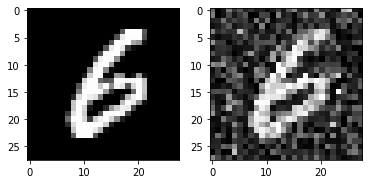

25  :  0.48634065820658506 25
50  :  0.49115210669816917 25
75  :  0.49317437656932955 25
100  :  0.49307470520435615 25
125  :  0.49307470520435615 25
150  :  0.49307470520435615 25
175  :  0.4932860980980307 25
200  :  0.4937347012092002 25
225  :  0.4936289380224374 25
250  :  0.4937294000007892 25
275  :  0.493754955498927 25
300  :  0.4937562208876073 25
325  :  0.4937562208876073 25
350  :  0.4940591958317704 25
375  :  0.4940591958317704 25
400  :  0.4940591958317704 25
425  :  0.4940591958317704 25
450  :  0.4941054904397188 25
475  :  0.4941903171632728 25
500  :  0.49419651999459024 25
525  :  0.49420066510571586 25
550  :  0.49422430120113353 25
575  :  0.4942761025212152 25
600  :  0.4942718834951184 25
625  :  0.49430284357601306 25
650  :  0.4943144391102141 25
675  :  0.49431440965883816 25
700  :  0.49431440965883816 25
725  :  0.4943257710796923 25
750  :  0.4943481647400129 25
775  :  0.4943595602040154 25
800  :  0.49438660437656395 25
Time:  33.959277391433716  seco

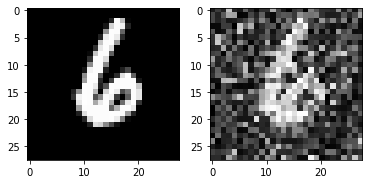

25  :  0.4805994164874864 25
50  :  0.4924096920536153 25
75  :  0.49324566515936324 25
100  :  0.49324566515936324 25
125  :  0.49325046116976157 25
150  :  0.4940024582832775 25
175  :  0.49415534033017694 25
200  :  0.49415534033017694 25
225  :  0.49415534033017694 25
250  :  0.49415534033017694 25
275  :  0.49415534033017694 25
300  :  0.49415534033017694 25
325  :  0.49415534033017694 25
350  :  0.49415534033017694 25
375  :  0.49415534033017694 25
400  :  0.49415534033017694 25
425  :  0.49415534033017694 25
450  :  0.494158123870743 25
475  :  0.4942075176257288 25
500  :  0.49422837021302163 25
525  :  0.49422837021302163 25
550  :  0.4943592762006359 25
575  :  0.4943592762006359 25
600  :  0.49447127704340155 25
625  :  0.49447670340575794 25
650  :  0.49447670340575794 25
675  :  0.49450645384212766 25
700  :  0.4945816187627533 25
725  :  0.4945816187627533 25
750  :  0.4945816187627533 25
775  :  0.4945961247368144 25
800  :  0.4945961247368144 25
825  :  0.49459612473681

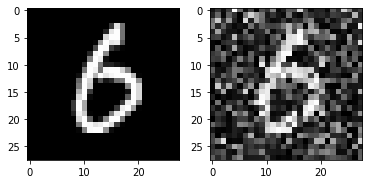

25  :  0.4862836346775814 25
50  :  0.49332527994561953 25
75  :  0.4931249343944044 25
100  :  0.49342050165705836 25
125  :  0.49365341997413775 25
150  :  0.49365341997413775 25
175  :  0.4938125778421316 25
200  :  0.4939917779041931 25
225  :  0.49403889896186587 25
250  :  0.4940388699691464 25
275  :  0.4940388699691464 25
300  :  0.49436160012350094 25
325  :  0.4943960263509709 25
350  :  0.4943960263509709 25
375  :  0.4943960263509709 25
400  :  0.4943960263509709 25
425  :  0.4943960263509709 25
450  :  0.4944065622925565 25
475  :  0.4944065622925565 25
500  :  0.4944241771819362 25
525  :  0.49450821398546 25
550  :  0.49450518121114995 25
575  :  0.4945263664743564 25
600  :  0.4945323425524095 25
625  :  0.4945388779217212 25
650  :  0.4945545860618772 25
675  :  0.49456682129105506 25
700  :  0.49456682129105506 25
725  :  0.4945790449717972 25
750  :  0.4945841898183833 25
775  :  0.4945864774865924 25
800  :  0.4945865697384011 25
Time:  34.220564126968384  seconds
P

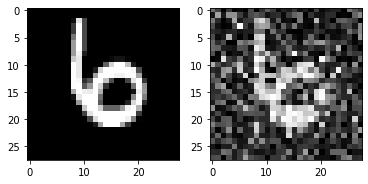

25  :  0.4942837510046814 25
50  :  0.4942837510046814 25
75  :  0.4941353415372583 25
100  :  0.4941258530486093 25
125  :  0.4945803559724198 25
150  :  0.49456214935979226 25
175  :  0.49456214935979226 25
200  :  0.49456214935979226 25
225  :  0.49456214935979226 25
250  :  0.4947159136369092 25
275  :  0.494573432449076 25
300  :  0.49460843635506624 25
325  :  0.49483798236834703 25
350  :  0.494853287301006 25
375  :  0.4948696129995204 25
400  :  0.4948864506631188 25
425  :  0.49487505803662984 25
450  :  0.49500963469203946 25
475  :  0.4950059393749311 25
500  :  0.4950059393749311 25
525  :  0.4950059393749311 25
550  :  0.4950059393749311 25
575  :  0.4950727639799182 25
600  :  0.49507282371097905 25
625  :  0.4951212160673475 25
650  :  0.4951543951052404 25
675  :  0.49516592844622725 25
700  :  0.4952142428602979 25
725  :  0.4952553059511641 25
750  :  0.4952594692479408 25
775  :  0.49526615194837237 25
800  :  0.4952898805981075 25
Time:  34.186885833740234  seconds

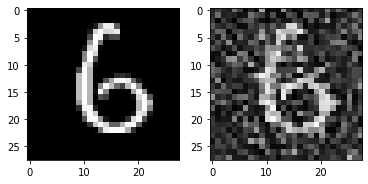

25  :  0.49433284833969776 25
50  :  0.49433284833969776 25
75  :  0.4939569601184729 25
100  :  0.4939569601184729 25
125  :  0.4939569601184729 25
150  :  0.4939569601184729 25
175  :  0.4939569601184729 25
200  :  0.4939569601184729 25
225  :  0.4939569601184729 25
250  :  0.49405831499056163 25
275  :  0.494443725349842 25
300  :  0.494443725349842 25
325  :  0.4945940985106206 25
350  :  0.4945940985106206 25
375  :  0.4946875829207755 25
400  :  0.4946875829207755 25
425  :  0.4946875829207755 25
450  :  0.49471766623515867 25
475  :  0.49471766623515867 25
500  :  0.49471766623515867 25
525  :  0.4947645303009659 25
550  :  0.4947645303009659 25
575  :  0.4947801475782302 25
600  :  0.4947853868839476 25
625  :  0.4947853868839476 25
650  :  0.49479495328267853 25
675  :  0.49480787104309026 25
700  :  0.49480787104309026 25
725  :  0.4948257231617012 25
750  :  0.49483602012220074 25
775  :  0.49485527103149907 25
800  :  0.4948674601995521 25
Time:  34.106541872024536  seconds

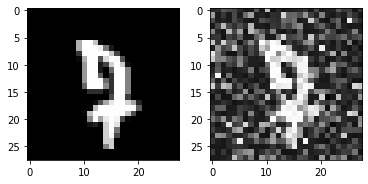

25  :  0.4949618440877592 25
50  :  0.4949618440877592 25
75  :  0.49499508116823376 25
100  :  0.49529927889891634 25
125  :  0.49511921094273154 25
150  :  0.4951036491178301 25
175  :  0.49518868840287666 25
200  :  0.4952049165762722 25
225  :  0.4953571108101244 25
250  :  0.4953581146148129 25
275  :  0.4953581146148129 25
300  :  0.49545842462156686 25
325  :  0.49547194861483995 25
350  :  0.49547194861483995 25
375  :  0.49556990470777657 25
400  :  0.49556990470777657 25
425  :  0.49556990470777657 25
450  :  0.49567380016525925 25
475  :  0.49567380016525925 25
500  :  0.49567380016525925 25
525  :  0.49567380016525925 25
550  :  0.49571056402791935 25
575  :  0.4957806871570518 25
600  :  0.4958123254640536 25
625  :  0.4958140795029729 25
650  :  0.49584608961373733 25
675  :  0.49589074723098336 25
700  :  0.49592113400245735 25
725  :  0.4959461875303221 25
750  :  0.4959559800189382 25
775  :  0.49596297758630215 25
800  :  0.4959726151299259 25
Time:  34.269695520401  

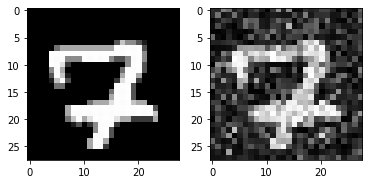

25  :  0.4932441397595849 25
50  :  0.4932441397595849 25
75  :  0.49344579797095184 25
100  :  0.49363197970468947 25
125  :  0.4936353579125409 25
150  :  0.4937233723341998 25
175  :  0.4937233723341998 25
200  :  0.4937233723341998 25
225  :  0.4937233723341998 25
250  :  0.493734691148218 25
275  :  0.49378754627603577 25
300  :  0.49378757124000805 25
325  :  0.49402764937667254 25
350  :  0.49407218433370964 25
375  :  0.49407218433370964 25
400  :  0.49407218433370964 25
425  :  0.49407218433370964 25
450  :  0.49407218433370964 25
475  :  0.49407218433370964 25
500  :  0.49420264765344774 25
525  :  0.49410069405364293 25
550  :  0.49410069405364293 25
575  :  0.49412435321649967 25
600  :  0.49413843124400103 25
625  :  0.4943131875379814 25
650  :  0.49433949007860783 25
675  :  0.49442361323666967 25
700  :  0.49442361323666967 25
725  :  0.49442361323666967 25
750  :  0.49442361323666967 25
775  :  0.49442361323666967 25
800  :  0.49445587931007107 25
Time:  34.24977803230

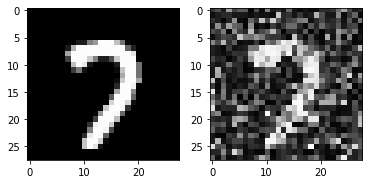

25  :  -0.1516873076812259 25
50  :  0.18355556176259608 25
75  :  0.49120936306448626 25
100  :  0.4926446012982175 25
125  :  0.492083223086091 25
150  :  0.49244126500516666 25
175  :  0.49244126500516666 25
200  :  0.49244126500516666 25
225  :  0.49244126500516666 25
250  :  0.49273884213112346 25
275  :  0.49253945019616296 25
300  :  0.49257188448314543 25
325  :  0.4928653212177639 25
350  :  0.492932396209556 25
375  :  0.4930626528072494 25
400  :  0.4930626528072494 25
425  :  0.4930626528072494 25
450  :  0.4930626528072494 25
475  :  0.4930626528072494 25
500  :  0.4930626528072494 25
525  :  0.49308353371229596 25
550  :  0.49310158831441725 25
575  :  0.49310364761516423 25
600  :  0.49311254136428273 25
625  :  0.4931662286304016 25
650  :  0.4932970347557639 25
675  :  0.4932980122830392 25
700  :  0.4932980122830392 25
725  :  0.4933586677822042 25
750  :  0.4933586677822042 25
775  :  0.4933586677822042 25
800  :  0.4933985157873586 25
825  :  0.4933985157873586 25
8

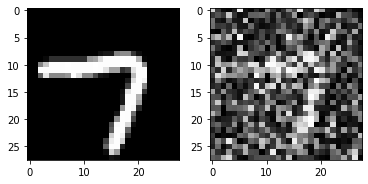

25  :  -0.09299282732361276 25
50  :  0.4908932872841601 25
75  :  0.4901385244185734 25
100  :  0.49115769102326173 25
125  :  0.491733172641702 25
150  :  0.49247892197615245 25
175  :  0.4929423714466315 25
200  :  0.4929423714466315 25
225  :  0.4929423714466315 25
250  :  0.4929423714466315 25
275  :  0.4929423714466315 25
300  :  0.4929423714466315 25
325  :  0.4929423714466315 25
350  :  0.4929423714466315 25
375  :  0.4929423714466315 25
400  :  0.49297423047050887 25
425  :  0.4932761967618602 25
450  :  0.4932761967618602 25
475  :  0.4932761967618602 25
500  :  0.4932761967618602 25
525  :  0.4932761967618602 25
550  :  0.4932761967618602 25
575  :  0.4934004656449957 25
600  :  0.4933888999440172 25
625  :  0.4933888999440172 25
650  :  0.4933888999440172 25
675  :  0.49347741705498993 25
700  :  0.49342334678172 25
725  :  0.4934625140545171 25
750  :  0.4934625140545171 25
775  :  0.4934625140545171 25
800  :  0.49354435483693193 25
825  :  0.49366127896954526 25
Time:  3

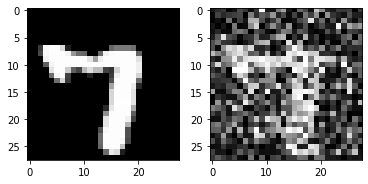

25  :  0.4951323577580886 25
50  :  0.4951323577580886 25
75  :  0.49517594958222955 25
100  :  0.49537221355505556 25
125  :  0.49537221355505556 25
150  :  0.49537221355505556 25
175  :  0.49537221355505556 25
200  :  0.49537221355505556 25
225  :  0.4953869678453307 25
250  :  0.4953890280634809 25
275  :  0.49539918330018373 25
300  :  0.4954867423883832 25
325  :  0.49556249674562547 25
350  :  0.495598113555659 25
375  :  0.495598113555659 25
400  :  0.495598113555659 25
425  :  0.4956553859077713 25
450  :  0.4957548838969351 25
475  :  0.49577192710104184 25
500  :  0.49585466105279835 25
525  :  0.49584948583056904 25
550  :  0.4958876311780011 25
575  :  0.4958876311780011 25
600  :  0.4958876311780011 25
625  :  0.4959382665483787 25
650  :  0.4959382665483787 25
675  :  0.4959382665483787 25
700  :  0.4959387755818103 25
725  :  0.49599319111395207 25
750  :  0.49599585364776727 25
775  :  0.4960546588141211 25
800  :  0.4960613636793978 25
Time:  34.258671283721924  second

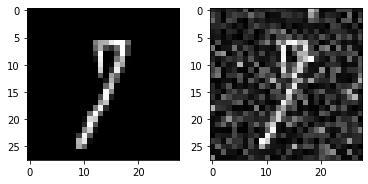

25  :  0.4914434413804592 25
50  :  0.4934336968518255 25
75  :  0.4942841934054261 25
100  :  0.4944909046567936 25
125  :  0.4944909046567936 25
150  :  0.4944909046567936 25
175  :  0.4944909046567936 25
200  :  0.4944909046567936 25
225  :  0.4945671265162976 25
250  :  0.4945744681382973 25
275  :  0.4945744681382973 25
300  :  0.4945744681382973 25
325  :  0.49472583776749585 25
350  :  0.49477314379049403 25
375  :  0.49477314379049403 25
400  :  0.49477314379049403 25
425  :  0.49477314379049403 25
450  :  0.49477314379049403 25
475  :  0.49477314379049403 25
500  :  0.49491271131512277 25
525  :  0.4949151609477514 25
550  :  0.49494476998622 25
575  :  0.49496616637471225 25
600  :  0.49500316014680523 25
625  :  0.49500316014680523 25
650  :  0.4950224723478626 25
675  :  0.49506266622083445 25
700  :  0.49506266622083445 25
725  :  0.49506266622083445 25
750  :  0.49506266622083445 25
775  :  0.4950809416818735 25
800  :  0.49508540482663393 25
Time:  35.30055260658264  sec

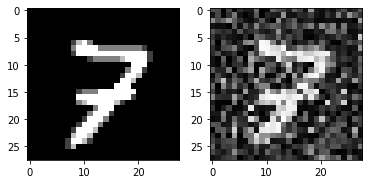

25  :  0.49443001746953535 25
50  :  0.4946175876223485 25
75  :  0.4947057353163154 25
100  :  0.4947057353163154 25
125  :  0.4947057353163154 25
150  :  0.4947057353163154 25
175  :  0.4947057353163154 25
200  :  0.4947057353163154 25
225  :  0.4947057353163154 25
250  :  0.4947057353163154 25
275  :  0.4947057353163154 25
300  :  0.4947057353163154 25
325  :  0.4947057353163154 25
350  :  0.49473321935322995 25
375  :  0.4947524923529744 25
400  :  0.4947524923529744 25
425  :  0.4947524923529744 25
450  :  0.4947813682566849 25
475  :  0.49497499389063804 25
500  :  0.4949733842069523 25
525  :  0.49506470211091513 25
550  :  0.49505877940880977 25
575  :  0.4950892988828638 25
600  :  0.4950916191902935 25
625  :  0.49510479485261905 25
650  :  0.49514633720316725 25
675  :  0.4951473053133403 25
700  :  0.49517065987923903 25
725  :  0.49517688945493504 25
750  :  0.49517688945493504 25
775  :  0.49518825806062033 25
800  :  0.49518822826117037 25
Time:  34.552266120910645  seco

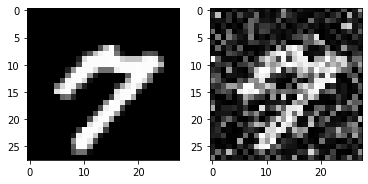

25  :  0.49053440124929537 25
50  :  0.49421576346026974 25
75  :  0.4939938087283308 25
100  :  0.4939938087283308 25
125  :  0.4939938087283308 25
150  :  0.4939938087283308 25
175  :  0.4939938087283308 25
200  :  0.4939938087283308 25
225  :  0.4939938087283308 25
250  :  0.4939938087283308 25
275  :  0.49418957088413984 25
300  :  0.4942288503827574 25
325  :  0.4942288503827574 25
350  :  0.4942288503827574 25
375  :  0.4942288503827574 25
400  :  0.4942288503827574 25
425  :  0.4942288503827574 25
450  :  0.4942288503827574 25
475  :  0.4942288503827574 25
500  :  0.494264369871826 25
525  :  0.494264369871826 25
550  :  0.494264369871826 25
575  :  0.494264369871826 25
600  :  0.494264369871826 25
625  :  0.494264369871826 25
650  :  0.494264369871826 25
675  :  0.494264369871826 25
700  :  0.494264369871826 25
725  :  0.494264369871826 25
750  :  0.494264369871826 25
775  :  0.494264369871826 25
800  :  0.494264369871826 25
Time:  34.28265976905823  seconds
Predicted class:  [

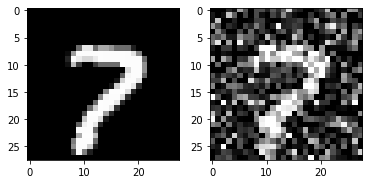

25  :  0.4876841015583145 25
50  :  0.492592306171679 25
75  :  0.4929187237086961 25
100  :  0.49322191255193476 25
125  :  0.4933987583702558 25
150  :  0.4933987583702558 25
175  :  0.4934238206896423 25
200  :  0.4934238206896423 25
225  :  0.4934238206896423 25
250  :  0.4934238206896423 25
275  :  0.4934238206896423 25
300  :  0.4934238206896423 25
325  :  0.4934617206497641 25
350  :  0.4936329131369002 25
375  :  0.4936329131369002 25
400  :  0.4938508214146958 25
425  :  0.4936704864721648 25
450  :  0.4936704864721648 25
475  :  0.4936704864721648 25
500  :  0.4936704864721648 25
525  :  0.4936704864721648 25
550  :  0.4936875182287388 25
575  :  0.49378999124401185 25
600  :  0.49378999124401185 25
625  :  0.49378999124401185 25
650  :  0.49378999124401185 25
675  :  0.49378999124401185 25
700  :  0.49380184918764053 25
725  :  0.4938131295838011 25
750  :  0.4938155298977115 25
775  :  0.4938155298977115 25
800  :  0.4938155298977115 25
Time:  34.148396015167236  seconds
Pr

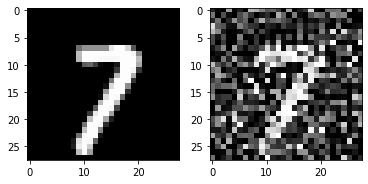

25  :  0.49213961297949754 25
50  :  0.4936414821309356 25
75  :  0.49332428376024423 25
100  :  0.49332428376024423 25
125  :  0.49332428376024423 25
150  :  0.49332428376024423 25
175  :  0.49332428376024423 25
200  :  0.49332428376024423 25
225  :  0.49334123473737185 25
250  :  0.49332428376024423 25
275  :  0.49332428376024423 25
300  :  0.49332428376024423 25
325  :  0.49339648442438583 25
350  :  0.4934707578028155 25
375  :  0.4935050487531924 25
400  :  0.4936435523430104 25
425  :  0.4936435523430104 25
450  :  0.49373601945714274 25
475  :  0.4938224368606078 25
500  :  0.4938224368606078 25
525  :  0.4938224368606078 25
550  :  0.4939635953433206 25
575  :  0.4939635953433206 25
600  :  0.4939635953433206 25
625  :  0.4940445616319066 25
650  :  0.4940445616319066 25
675  :  0.4940445616319066 25
700  :  0.49408018855171965 25
725  :  0.49407869689103356 25
750  :  0.49407869689103356 25
775  :  0.4941428726250678 25
800  :  0.49421088467052887 25
Time:  34.35026001930237  

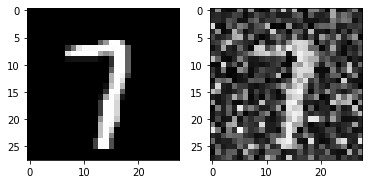

25  :  0.49248513487213674 25
50  :  0.49415367795071513 25
75  :  0.4929817578799149 25
100  :  0.4932680206976742 25
125  :  0.4933950088663076 25
150  :  0.49336353507423997 25
175  :  0.4933873427773693 25
200  :  0.4934592931438386 25
225  :  0.4934592931438386 25
250  :  0.4934592931438386 25
275  :  0.49366202218031324 25
300  :  0.49371769174821073 25
325  :  0.49371769174821073 25
350  :  0.49375853950847204 25
375  :  0.49374422561078807 25
400  :  0.4937239892526777 25
425  :  0.4937239892526777 25
450  :  0.49389523267756125 25
475  :  0.49389523267756125 25
500  :  0.49389523267756125 25
525  :  0.49389523267756125 25
550  :  0.4939275583352031 25
575  :  0.49401909265478516 25
600  :  0.49425983277149815 25
625  :  0.49426705193087167 25
650  :  0.49426705193087167 25
675  :  0.49426705193087167 25
700  :  0.49426705193087167 25
725  :  0.49426705193087167 25
750  :  0.49426705193087167 25
775  :  0.49428242282743334 25
800  :  0.49428242282743334 25
Time:  34.17972040176

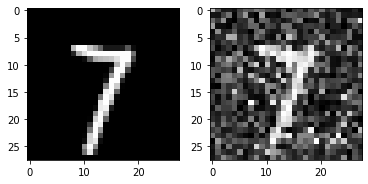

25  :  0.48904833598530456 25
50  :  0.4929214151088057 25
75  :  0.4924857988145033 25
100  :  0.4929794168532093 25
125  :  0.4922488061836785 25
150  :  0.49254285917805934 25
175  :  0.49254285917805934 25
200  :  0.49254285917805934 25
225  :  0.49254285917805934 25
250  :  0.49254285917805934 25
275  :  0.4925548209536714 25
300  :  0.4926366050743221 25
325  :  0.4926606408955523 25
350  :  0.4927635634445795 25
375  :  0.49307848137712224 25
400  :  0.49307963478086597 25
425  :  0.4933777919294539 25
450  :  0.4933777919294539 25
475  :  0.4933777919294539 25
500  :  0.49357608392071567 25
525  :  0.49359689277559227 25
550  :  0.49361868553951893 25
575  :  0.4937214292584541 25
600  :  0.49377177893307417 25
625  :  0.49377177893307417 25
650  :  0.49377177893307417 25
675  :  0.4938028057581303 25
700  :  0.4938369953603842 25
725  :  0.4938876036799757 25
750  :  0.4938924713667159 25
775  :  0.49391916977028394 25
800  :  0.4939504522250006 25
Time:  34.428078413009644  s

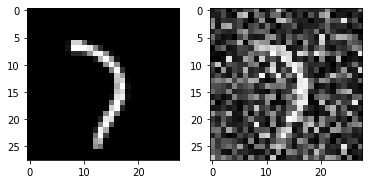

25  :  -0.5043156616086903 25
50  :  -0.5035117773916219 25
75  :  -0.40015633036243553 25
100  :  -0.4224384864601704 25
125  :  -0.30662604499184776 25
150  :  0.4919093673398458 25
175  :  0.4881197949647232 25
200  :  0.4886838819681483 25
225  :  0.49000038275583874 25
250  :  0.48860129740852126 25
275  :  0.4886156070986006 25
300  :  0.48957067790234937 25
325  :  0.49028977890196274 25
350  :  0.4913300025573566 25
375  :  0.49120371827925663 25
400  :  0.4917281062031355 25
425  :  0.49120371827925663 25
450  :  0.49120371827925663 25
475  :  0.49120371827925663 25
500  :  0.49143094649446023 25
525  :  0.4915075687929607 25
550  :  0.4917378032029696 25
575  :  0.4918415467113861 25
600  :  0.4921281240206588 25
625  :  0.4921281240206588 25
650  :  0.4921281240206588 25
675  :  0.4921281240206588 25
700  :  0.49212867662636467 25
725  :  0.49218787862910973 25
750  :  0.4923210957090713 25
775  :  0.4923340665583456 25
800  :  0.4923352601943581 25
825  :  0.492353115598919

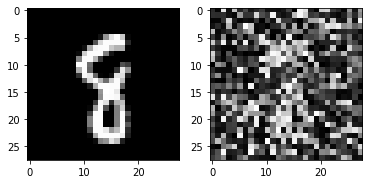

25  :  -0.4946342060930313 25
50  :  -0.4946342060930313 25
75  :  -0.4832328887531546 25
100  :  -0.5003728995714048 25
125  :  -0.5003728995714048 25
150  :  -0.5003728995714048 25
175  :  -0.3787655203641369 25
200  :  -0.4465373731765524 25
225  :  -0.39076067319088426 25
250  :  -0.03156719606471778 25
275  :  -0.3303390685666578 25
300  :  0.48308607516738666 25
325  :  0.4914044355337346 25
350  :  0.4918449714770144 25
375  :  0.4914908227564132 25
400  :  0.4914908227564132 25
425  :  0.4914908227564132 25
450  :  0.49180586914318913 25
475  :  0.4925234624663146 25
500  :  0.4925234624663146 25
525  :  0.4925234624663146 25
550  :  0.4925234624663146 25
575  :  0.4925234624663146 25
600  :  0.4925234624663146 25
625  :  0.4925234624663146 25
650  :  0.4925234624663146 25
675  :  0.4925234624663146 25
700  :  0.4925234624663146 25
725  :  0.4925234624663146 25
750  :  0.4925234624663146 25
775  :  0.4925234624663146 25
800  :  0.4926256010223699 25
825  :  0.49264767009799215 

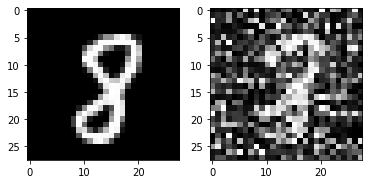

25  :  -0.5046346530840096 25
50  :  -0.5046022042629591 25
75  :  -0.5044443901225126 25
100  :  -0.5039791479111394 25
125  :  -0.5039791479111394 25
150  :  -0.5039242238608403 25
175  :  -0.5036884023884771 25
200  :  -0.5036884023884771 25
225  :  -0.5036884023884771 25
250  :  -0.5036287639504365 25
275  :  -0.5036287639504365 25
300  :  -0.5034616479491005 25
325  :  -0.5034612019947544 25
350  :  -0.5034612019947544 25
375  :  -0.5034612019947544 25
400  :  -0.5034048476707083 25
425  :  -0.5033755083038997 25
450  :  -0.5033755082217817 25
475  :  -0.5033636513104123 25
500  :  -0.5033636513104123 25
525  :  -0.5033532663432564 25
550  :  -0.5033241046584161 25
575  :  -0.5033155198257036 25
600  :  -0.5033077545085656 25
625  :  -0.5032947139610594 25
650  :  -0.5032852818060949 25
675  :  -0.5032741460047749 25
700  :  -0.5032640317904025 25
725  :  -0.5032638248258324 25
750  :  -0.5032617430251817 25
775  :  -0.5032534256780123 25
800  :  -0.5032499587265621 25
Time:  34.4

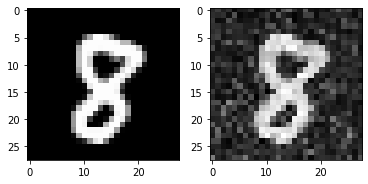

25  :  -0.504518464033903 25
50  :  -0.504518464033903 25
75  :  -0.5042474421753308 25
100  :  -0.5038391148317986 25
125  :  -0.5034944772024599 25
150  :  -0.5034944772024599 25
175  :  -0.5034582221199481 25
200  :  -0.5034566563565748 25
225  :  -0.5034566563565748 25
250  :  -0.5031851280250363 25
275  :  -0.5031851280250363 25
300  :  -0.5031851280250363 25
325  :  -0.5031851280250363 25
350  :  -0.5031851280250363 25
375  :  -0.5031851280250363 25
400  :  -0.5031851280250363 25
425  :  -0.5031820596042937 25
450  :  -0.5031820596042937 25
475  :  -0.5031499881649639 25
500  :  -0.5031499881649639 25
525  :  -0.5031499881649639 25
550  :  -0.5031308722117168 25
575  :  -0.5031169050315555 25
600  :  -0.5031169050315555 25
625  :  -0.5031077053490588 25
650  :  -0.5031041175209555 25
675  :  -0.5031041175209555 25
700  :  -0.5030906503791581 25
725  :  -0.5030866240699596 25
750  :  -0.5030769444176144 25
775  :  -0.5030769444176144 25
800  :  -0.5030760792077862 25
Time:  34.610

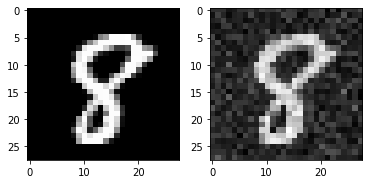

25  :  -0.5042587575449593 25
50  :  -0.5042587575449593 25
75  :  -0.5039874384664643 25
100  :  -0.5039874384664643 25
125  :  -0.5039521013552517 25
150  :  -0.5038131754401788 25
175  :  -0.5037601175720284 25
200  :  -0.5035553084540624 25
225  :  -0.5035553084540624 25
250  :  -0.5035553084540624 25
275  :  -0.5034975722793027 25
300  :  -0.5034415911260879 25
325  :  -0.5033696136641725 25
350  :  -0.5033523050995462 25
375  :  -0.5033248735685645 25
400  :  -0.5033248735685645 25
425  :  -0.503308112829967 25
450  :  -0.5033080875269599 25
475  :  -0.5033026888278345 25
500  :  -0.5033026858705286 25
525  :  -0.5032953190585785 25
550  :  -0.5032733937492643 25
575  :  -0.5032372339537625 25
600  :  -0.5032372264995799 25
625  :  -0.5032316173433221 25
650  :  -0.5032175567809742 25
675  :  -0.503166208525611 25
700  :  -0.503166208525611 25
725  :  -0.5031563942368006 25
750  :  -0.503152921528562 25
775  :  -0.5031445217700746 25
800  :  -0.5031393139687939 25
Time:  34.73280

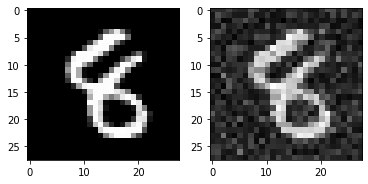

25  :  -0.504571787876366 25
50  :  -0.504538314793716 25
75  :  -0.5043305927719763 25
100  :  -0.5042439528503313 25
125  :  -0.5039914330711716 25
150  :  -0.5039485486091507 25
175  :  -0.5037422187683902 25
200  :  -0.5037422187683902 25
225  :  -0.5037354700726316 25
250  :  -0.5035409362014289 25
275  :  -0.5035409362014289 25
300  :  -0.5034641551817248 25
325  :  -0.5034641551817248 25
350  :  -0.5034641551817248 25
375  :  -0.503459607467425 25
400  :  -0.5034134846567242 25
425  :  -0.5033520211667812 25
450  :  -0.5033092350892959 25
475  :  -0.5033092350892959 25
500  :  -0.5032673754368858 25
525  :  -0.5032301324742281 25
550  :  -0.5032300800111122 25
575  :  -0.5032201238938094 25
600  :  -0.5032201238938094 25
625  :  -0.5032141029996217 25
650  :  -0.5032068272063839 25
675  :  -0.5031936238944126 25
700  :  -0.5031766515585695 25
725  :  -0.5031766515585695 25
750  :  -0.5031582167441886 25
775  :  -0.5031580551491384 25
800  :  -0.5031445847984506 25
Time:  34.6837

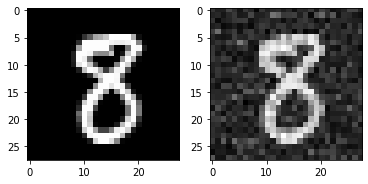

25  :  -0.5044918965547613 25
50  :  -0.5043787192661429 25
75  :  -0.5041757189867357 25
100  :  -0.5040458195046131 25
125  :  -0.5039658882751225 25
150  :  -0.5039631895050553 25
175  :  -0.5039273334676521 25
200  :  -0.5037386726276802 25
225  :  -0.5036871451564422 25
250  :  -0.5036571608485658 25
275  :  -0.5036261104494029 25
300  :  -0.5036039205595402 25
325  :  -0.5034711274843865 25
350  :  -0.5033868631997505 25
375  :  -0.5033867269755251 25
400  :  -0.5033603626491974 25
425  :  -0.5033603626491974 25
450  :  -0.5033565269579592 25
475  :  -0.5033158862694184 25
500  :  -0.5033158862694184 25
525  :  -0.5032431353987273 25
550  :  -0.5032431353987273 25
575  :  -0.5032431353987273 25
600  :  -0.5032357506999521 25
625  :  -0.5032310094998139 25
650  :  -0.5032249376327841 25
675  :  -0.5032249376327841 25
700  :  -0.5032099999624264 25
725  :  -0.5032023801860924 25
750  :  -0.5032012652402826 25
775  :  -0.5031942397273629 25
800  :  -0.5031812877518005 25
Time:  34.4

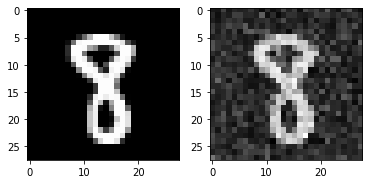

25  :  0.30344535002914114 25
50  :  0.30344535002914114 25
75  :  0.4933793452970204 25
100  :  0.49253672790020486 25
125  :  0.4919909982801699 25
150  :  0.4931596497642936 25
175  :  0.4931596497642936 25
200  :  0.4931596497642936 25
225  :  0.4936623681936274 25
250  :  0.49364907870958946 25
275  :  0.49364907870958946 25
300  :  0.49364907870958946 25
325  :  0.49364907870958946 25
350  :  0.4939797332855731 25
375  :  0.49399830261198596 25
400  :  0.49399830261198596 25
425  :  0.49402064842891896 25
450  :  0.49402064842891896 25
475  :  0.4940477880078727 25
500  :  0.4940905430422574 25
525  :  0.49417533952818754 25
550  :  0.49417533952818754 25
575  :  0.49421636978488764 25
600  :  0.4942740914397896 25
625  :  0.49438371402288 25
650  :  0.49438371402288 25
675  :  0.49438371402288 25
700  :  0.49438371402288 25
725  :  0.4943844223044249 25
750  :  0.4943844223044249 25
775  :  0.49440313367608935 25
800  :  0.4944045382925577 25
825  :  0.4944263629007351 25
850  :

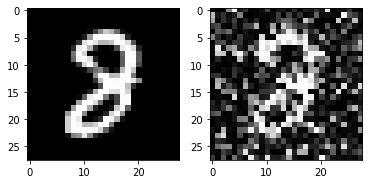

25  :  -0.5045089118207966 25
50  :  -0.5044459605243934 25
75  :  -0.48929702894539706 25
100  :  -0.49751966195917363 25
125  :  -0.49190557389137535 25
150  :  -0.49767725861086565 25
175  :  -0.48749627907274895 25
200  :  -0.30622689754614774 25
225  :  -0.19080600372060136 25
250  :  -0.17707512275653906 25
275  :  0.12435911381191 25
300  :  0.3874983928542973 25
325  :  0.4799146005718276 25
350  :  0.4899101643959052 25
375  :  0.48980073907518645 25
400  :  0.4908286542988236 25
425  :  0.4907196700930174 25
450  :  0.490868794104704 25
475  :  0.4914544029998931 25
500  :  0.49132223172750344 25
525  :  0.49142635744691604 25
550  :  0.4917108740978925 25
575  :  0.49171590233523205 25
600  :  0.4917776526502365 25
625  :  0.49178920883511595 25
650  :  0.49181844109175094 25
675  :  0.4920081521527649 25
700  :  0.4920081521527649 25
725  :  0.49207783667567667 25
750  :  0.49211511794869534 25
775  :  0.4921385413827049 25
800  :  0.49218478542194694 25
825  :  0.492261422

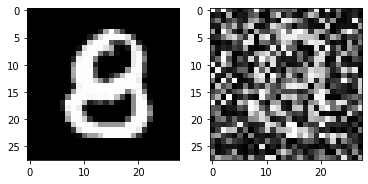

25  :  -0.49903926477228006 25
50  :  -0.4710959388560313 25
75  :  -0.47221406919287967 25
100  :  -0.4725679847869996 25
125  :  -0.16548911365873636 25
150  :  -0.10567431843955839 25
175  :  -0.10567431843955839 25
200  :  0.22624796698795385 25
225  :  0.4910909486652822 25
250  :  0.4910121313081276 25
275  :  0.48940525314531746 25
300  :  0.4921876867684562 25
325  :  0.4923061342833099 25
350  :  0.49241558542862257 25
375  :  0.4927166623139696 25
400  :  0.4927166623139696 25
425  :  0.49275631535359615 25
450  :  0.49289045967312384 25
475  :  0.49275631535359615 25
500  :  0.49275631535359615 25
525  :  0.4934256935156512 25
550  :  0.4934661020978041 25
575  :  0.4937334621698681 25
600  :  0.49373252185641325 25
625  :  0.4937434402548532 25
650  :  0.493808923959951 25
675  :  0.4938225801396192 25
700  :  0.4938225801396192 25
725  :  0.4939460612976908 25
750  :  0.49395409282251923 25
775  :  0.49395409282251923 25
800  :  0.49395409282251923 25
825  :  0.49395409282

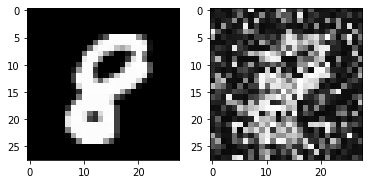

25  :  -0.4692306523067193 25
50  :  0.48594779099404 25
75  :  -0.07842885649582627 25
100  :  0.47256195400745915 25
125  :  0.2740473565773523 25
150  :  0.489007931188743 25
175  :  0.4918371384588468 25
200  :  0.4901042344862944 25
225  :  0.4916498642808436 25
250  :  0.4916498642808436 25
275  :  0.49167618530638474 25
300  :  0.4916900948138447 25
325  :  0.4917690433477067 25
350  :  0.49189502711489436 25
375  :  0.49191550917699095 25
400  :  0.49191550917699095 25
425  :  0.4921183868652607 25
450  :  0.49238213081875254 25
475  :  0.4924874733205886 25
500  :  0.4924874733205886 25
525  :  0.4924874733205886 25
550  :  0.4924874733205886 25
575  :  0.49264454894309995 25
600  :  0.49274274563105724 25
625  :  0.49274322681661475 25
650  :  0.49274322681661475 25
675  :  0.49276468813224744 25
700  :  0.49276468813224744 25
725  :  0.4927771444889931 25
750  :  0.49277723407336466 25
775  :  0.4928038688734008 25
800  :  0.4928196220823358 25
825  :  0.49282476880076337 25

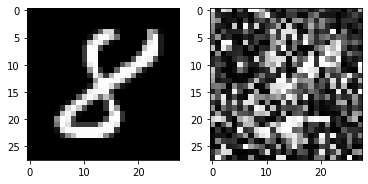

25  :  -0.5045771813542896 25
50  :  -0.504362922516815 25
75  :  -0.5040141597786437 25
100  :  -0.5040036696038591 25
125  :  -0.5040036696038591 25
150  :  -0.5035166303225099 25
175  :  -0.5035166303225099 25
200  :  -0.5035166303225099 25
225  :  -0.5035166303225099 25
250  :  -0.5034186733985475 25
275  :  -0.5034186733985475 25
300  :  -0.5034186733985475 25
325  :  -0.5032425416684467 25
350  :  -0.47522673978272334 25
375  :  -0.37179483137133384 25
400  :  0.474270423089378 25
425  :  0.46912623277853654 25
450  :  0.4193962801347318 25
475  :  0.4841179444607323 25
500  :  0.4755848318166708 25
525  :  0.48641859085541955 25
550  :  0.4867013796349222 25
575  :  0.48777537517580344 25
600  :  0.49064381115596967 25
625  :  0.49153907616077935 25
650  :  0.49120410315099394 25
675  :  0.49136460113442293 25
700  :  0.49177174101578003 25
725  :  0.49173248966763033 25
750  :  0.4920723568275707 25
775  :  0.49218923324389013 25
800  :  0.492358146963209 25
825  :  0.492203863

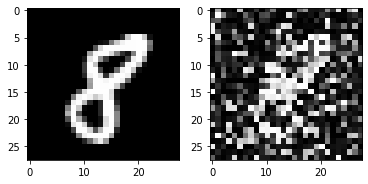

25  :  0.4938572460785195 25
50  :  0.4938572460785195 25
75  :  0.49446509176190523 25
100  :  0.49446509176190523 25
125  :  0.49446509176190523 25
150  :  0.49446509176190523 25
175  :  0.49446509176190523 25
200  :  0.49474562685006573 25
225  :  0.49482518121063185 25
250  :  0.49482518121063185 25
275  :  0.49482518121063185 25
300  :  0.49482518121063185 25
325  :  0.4949156372544113 25
350  :  0.4951103103767061 25
375  :  0.49511287448000524 25
400  :  0.49511287448000524 25
425  :  0.49518798837619415 25
450  :  0.49518767834938415 25
475  :  0.49518767834938415 25
500  :  0.49518767834938415 25
525  :  0.49526102613935236 25
550  :  0.49526102613935236 25
575  :  0.49529846746431333 25
600  :  0.4953079951743061 25
625  :  0.4953143379756899 25
650  :  0.4953182202064237 25
675  :  0.49534058522835334 25
700  :  0.4953404961127456 25
725  :  0.4953404961127456 25
750  :  0.4953473437082022 25
775  :  0.4953520941006448 25
800  :  0.49535934609488996 25
Time:  35.384897232055

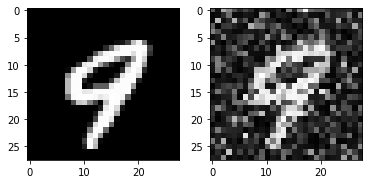

25  :  0.49229208353162524 25
50  :  0.4934917200325588 25
75  :  0.4938821277415898 25
100  :  0.4938821277415898 25
125  :  0.4938821277415898 25
150  :  0.4938821277415898 25
175  :  0.4939655216395495 25
200  :  0.49424175020976413 25
225  :  0.49424175020976413 25
250  :  0.49424175020976413 25
275  :  0.49453235924559485 25
300  :  0.49450850967932786 25
325  :  0.49454938483210226 25
350  :  0.4945020637840995 25
375  :  0.4945020637840995 25
400  :  0.4945020637840995 25
425  :  0.4945020637840995 25
450  :  0.49457639054559405 25
475  :  0.49457639054559405 25
500  :  0.49457639054559405 25
525  :  0.494726605006073 25
550  :  0.4946865148196148 25
575  :  0.494761227077677 25
600  :  0.494761227077677 25
625  :  0.49486972758899095 25
650  :  0.49493448367173526 25
675  :  0.49493327793495334 25
700  :  0.49496234751772616 25
725  :  0.49497359147363756 25
750  :  0.49503137148529264 25
775  :  0.4950322735021045 25
800  :  0.49505332836951726 25
Time:  35.48942828178406  sec

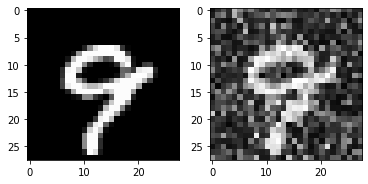

25  :  0.4943397385163568 25
50  :  0.4943397385163568 25
75  :  0.4945744511667691 25
100  :  0.4945744511667691 25
125  :  0.4945744511667691 25
150  :  0.4945744511667691 25
175  :  0.4945744511667691 25
200  :  0.4945744511667691 25
225  :  0.4945744511667691 25
250  :  0.4945744511667691 25
275  :  0.49457601933168754 25
300  :  0.49457601933168754 25
325  :  0.4945800855474397 25
350  :  0.4945798114452035 25
375  :  0.4945798114452035 25
400  :  0.4945798114452035 25
425  :  0.49462640688875703 25
450  :  0.4946802382559924 25
475  :  0.4949139745173608 25
500  :  0.49492093900414463 25
525  :  0.4950272586429958 25
550  :  0.49502801646326405 25
575  :  0.49502801646326405 25
600  :  0.49502801646326405 25
625  :  0.49509782540783215 25
650  :  0.49510438456812117 25
675  :  0.49510438456812117 25
700  :  0.49510438456812117 25
725  :  0.49510438456812117 25
750  :  0.49510438456812117 25
775  :  0.49510438456812117 25
800  :  0.4951410925611153 25
Time:  35.32330274581909  sec

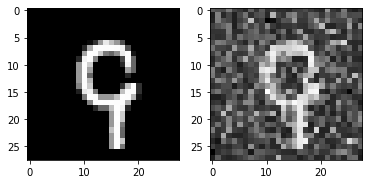

25  :  0.49521034061729124 25
50  :  0.49521034061729124 25
75  :  0.4950877464318415 25
100  :  0.49509264636728306 25
125  :  0.4951170177302379 25
150  :  0.4951170177302379 25
175  :  0.4951170177302379 25
200  :  0.4952654785283941 25
225  :  0.4952654785283941 25
250  :  0.4952654785283941 25
275  :  0.4952654785283941 25
300  :  0.4952654785283941 25
325  :  0.4952654785283941 25
350  :  0.49542997080476187 25
375  :  0.49542997080476187 25
400  :  0.49542997080476187 25
425  :  0.49542997080476187 25
450  :  0.49543334127168137 25
475  :  0.4954845681455007 25
500  :  0.4955237277324552 25
525  :  0.4955237277324552 25
550  :  0.4955530356788374 25
575  :  0.49558441847376655 25
600  :  0.4956294166777724 25
625  :  0.49563595198326266 25
650  :  0.4956813302857465 25
675  :  0.4956798913706121 25
700  :  0.4956903292912473 25
725  :  0.49570367281487127 25
750  :  0.49570367281487127 25
775  :  0.4957051398328736 25
800  :  0.49570528608439574 25
Time:  35.491947174072266  sec

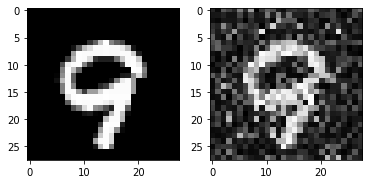

25  :  0.4945168081067905 25
50  :  0.4945168081067905 25
75  :  0.4945334009610095 25
100  :  0.4945334009610095 25
125  :  0.49456420249498045 25
150  :  0.4946370989841084 25
175  :  0.4947582958843445 25
200  :  0.4947582958843445 25
225  :  0.4947582958843445 25
250  :  0.4947582958843445 25
275  :  0.4947582958843445 25
300  :  0.4947582958843445 25
325  :  0.4948280594322286 25
350  :  0.4950398280133031 25
375  :  0.4950398280133031 25
400  :  0.4950398280133031 25
425  :  0.4950398280133031 25
450  :  0.49504580051037905 25
475  :  0.4950743488773168 25
500  :  0.4951358721275455 25
525  :  0.49519293019211297 25
550  :  0.49519293019211297 25
575  :  0.4952445675291116 25
600  :  0.4952572415891388 25
625  :  0.49525692540989413 25
650  :  0.49525692540989413 25
675  :  0.4953234801598966 25
700  :  0.4953234801598966 25
725  :  0.4953234801598966 25
750  :  0.4953311376599923 25
775  :  0.4953378833908584 25
800  :  0.4953699021610443 25
Time:  35.40774893760681  seconds
Pre

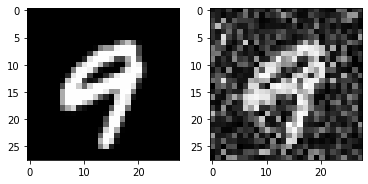

25  :  0.4950170853091033 25
50  :  0.4950170853091033 25
75  :  0.49503067777377796 25
100  :  0.49503067777377796 25
125  :  0.4950463284652579 25
150  :  0.49512524716032524 25
175  :  0.49512524716032524 25
200  :  0.495138501781448 25
225  :  0.49515516544211524 25
250  :  0.49520318567354776 25
275  :  0.49516604572564127 25
300  :  0.49537366688149 25
325  :  0.49537046149346575 25
350  :  0.49537046149346575 25
375  :  0.49540688891368906 25
400  :  0.4953959574388533 25
425  :  0.4953959574388533 25
450  :  0.4953959574388533 25
475  :  0.49553907926075114 25
500  :  0.49553907926075114 25
525  :  0.49553907926075114 25
550  :  0.49553907926075114 25
575  :  0.49555252845639636 25
600  :  0.49556886567328334 25
625  :  0.49556886567328334 25
650  :  0.4956225311703444 25
675  :  0.4956357867834664 25
700  :  0.49563554810724125 25
725  :  0.49571369567762175 25
750  :  0.49572463795079236 25
775  :  0.49572463795079236 25
800  :  0.49572463795079236 25
Time:  36.61630845069885

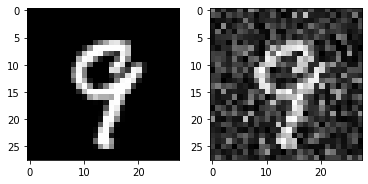

25  :  0.49503290887196727 25
50  :  0.49503290887196727 25
75  :  0.49503290887196727 25
100  :  0.4950545585268902 25
125  :  0.4950545585268902 25
150  :  0.4950545585268902 25
175  :  0.4950545585268902 25
200  :  0.4950545585268902 25
225  :  0.4950545585268902 25
250  :  0.4950545585268902 25
275  :  0.4950545585268902 25
300  :  0.4952448614628744 25
325  :  0.4952448614628744 25
350  :  0.4952448614628744 25
375  :  0.4952448614628744 25
400  :  0.4952448614628744 25
425  :  0.4952448614628744 25
450  :  0.4952448614628744 25
475  :  0.4952448614628744 25
500  :  0.49524512102778545 25
525  :  0.49524512102778545 25
550  :  0.49524512102778545 25
575  :  0.49524512102778545 25
600  :  0.4954003560934917 25
625  :  0.4954002689937692 25
650  :  0.4954677831115653 25
675  :  0.4955038279498233 25
700  :  0.49549732016331494 25
725  :  0.49549923408482605 25
750  :  0.49555148365773966 25
775  :  0.49556270433527144 25
800  :  0.4956250428557165 25
Time:  35.33469820022583  second

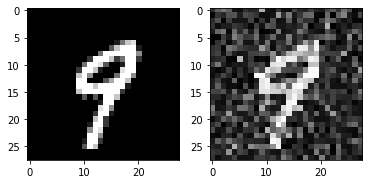

25  :  0.49508320809383843 25
50  :  0.49508320809383843 25
75  :  0.4952221702444578 25
100  :  0.495224870187369 25
125  :  0.495224870187369 25
150  :  0.495224870187369 25
175  :  0.495224870187369 25
200  :  0.4952753358925797 25
225  :  0.495256698414889 25
250  :  0.495256698414889 25
275  :  0.495256698414889 25
300  :  0.495256698414889 25
325  :  0.495256698414889 25
350  :  0.49531067390933303 25
375  :  0.495267289267419 25
400  :  0.49555481526498785 25
425  :  0.49555481526498785 25
450  :  0.49555481526498785 25
475  :  0.49555481526498785 25
500  :  0.49555481526498785 25
525  :  0.49555481526498785 25
550  :  0.4956700724794081 25
575  :  0.49566886527689413 25
600  :  0.49566886527689413 25
625  :  0.49566886527689413 25
650  :  0.49572287423438094 25
675  :  0.495758183725671 25
700  :  0.4957855595155286 25
725  :  0.4957855598216174 25
750  :  0.4957855598216174 25
775  :  0.4957974827121093 25
800  :  0.49580134505953927 25
Time:  35.14674735069275  seconds
Predic

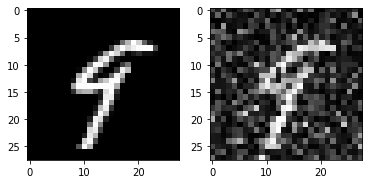

25  :  0.4942772766372505 25
50  :  0.4942772766372505 25
75  :  0.4942772766372505 25
100  :  0.4942772766372505 25
125  :  0.4942772766372505 25
150  :  0.4943775963405955 25
175  :  0.4943775963405955 25
200  :  0.4943775963405955 25
225  :  0.4943775963405955 25
250  :  0.4943775963405955 25
275  :  0.4943775963405955 25
300  :  0.4945771538476291 25
325  :  0.49463112382301005 25
350  :  0.49463420589049373 25
375  :  0.49463420589049373 25
400  :  0.49473551639589736 25
425  :  0.49474595330668275 25
450  :  0.49474595330668275 25
475  :  0.49486795886567153 25
500  :  0.49490889320467196 25
525  :  0.49491745896511324 25
550  :  0.49491745896511324 25
575  :  0.49491745896511324 25
600  :  0.49491745896511324 25
625  :  0.49491745896511324 25
650  :  0.494927149966368 25
675  :  0.49499061857894644 25
700  :  0.49499061857894644 25
725  :  0.49499061857894644 25
750  :  0.4950354299113557 25
775  :  0.49511997253056667 25
800  :  0.4951199725305679 25
Time:  34.8351891040802  se

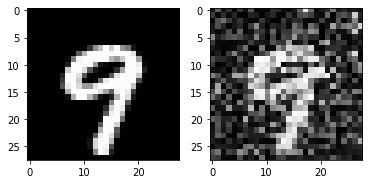

25  :  0.4938691474838086 25
50  :  0.4942678265153945 25
75  :  0.49472774614639664 25
100  :  0.4947123047081383 25
125  :  0.4947123047081383 25
150  :  0.4947123047081383 25
175  :  0.4947123047081383 25
200  :  0.4947123047081383 25
225  :  0.4947123047081383 25
250  :  0.4947123047081383 25
275  :  0.4947123047081383 25
300  :  0.4947123047081383 25
325  :  0.49478737810091505 25
350  :  0.494824323826852 25
375  :  0.4947517614302118 25
400  :  0.4947517614302118 25
425  :  0.4947517614302118 25
450  :  0.4947517614302118 25
475  :  0.49482365182804355 25
500  :  0.49477817633345833 25
525  :  0.49477817633345833 25
550  :  0.4949206895502545 25
575  :  0.49497051538594616 25
600  :  0.4950276612165083 25
625  :  0.49503488686364283 25
650  :  0.4950489086586716 25
675  :  0.4950489086586716 25
700  :  0.4950489086586716 25
725  :  0.4950489086586716 25
750  :  0.49506948479299806 25
775  :  0.4951558413546257 25
800  :  0.4951538981180667 25
Time:  35.00260829925537  seconds
Pr

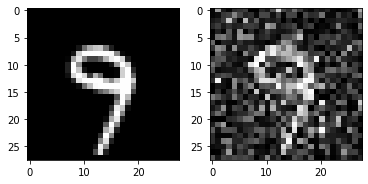

25  :  0.4946557217325685 25
50  :  0.49471052934718546 25
75  :  0.49487758156895384 25
100  :  0.4949763995679494 25
125  :  0.49494079904890914 25
150  :  0.49494079904890914 25
175  :  0.49523729937143474 25
200  :  0.4953524707181132 25
225  :  0.4953524707181132 25
250  :  0.4953524707181132 25
275  :  0.49541097833880476 25
300  :  0.49541097833880476 25
325  :  0.49541097833880476 25
350  :  0.49541097833880476 25
375  :  0.49541097833880476 25
400  :  0.49542280819188894 25
425  :  0.49547901596710187 25
450  :  0.49547901596710187 25
475  :  0.49547901596710187 25
500  :  0.49547901596710187 25
525  :  0.49547901596710187 25
550  :  0.49547901596710187 25
575  :  0.4955387856659342 25
600  :  0.4955387856659342 25
625  :  0.49568157531113105 25
650  :  0.4956958475255428 25
675  :  0.495695427876195 25
700  :  0.4957385827732867 25
725  :  0.4957697986844199 25
750  :  0.495789109864229 25
775  :  0.4957871422441493 25
800  :  0.4958074293715706 25
Time:  34.9965717792511  se

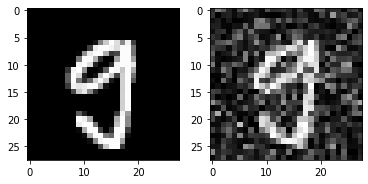

25  :  0.4825077357288614 25
50  :  0.4938464482911652 25
75  :  0.4940144832579985 25
100  :  0.4941958831058623 25
125  :  0.4941958831058623 25
150  :  0.4941958831058623 25
175  :  0.4941958831058623 25
200  :  0.4942546585437626 25
225  :  0.4942514551238407 25
250  :  0.4942514551238407 25
275  :  0.49428970959919033 25
300  :  0.49443680988455974 25
325  :  0.49443680988455974 25
350  :  0.49445661499867827 25
375  :  0.49450402461477594 25
400  :  0.49469875632053373 25
425  :  0.4947200289572804 25
450  :  0.49491026451397097 25
475  :  0.4949124603060135 25
500  :  0.49491246036939174 25
525  :  0.4949332212608828 25
550  :  0.4949486824426812 25
575  :  0.4949724132366642 25
600  :  0.49497140688623964 25
625  :  0.49497140688623964 25
650  :  0.49497140688623964 25
675  :  0.49497140688623964 25
700  :  0.49498642533624926 25
725  :  0.4950120165822381 25
750  :  0.4950120165822381 25
775  :  0.4950183717250732 25
800  :  0.4950293481024503 25
825  :  0.49503594373071313 25

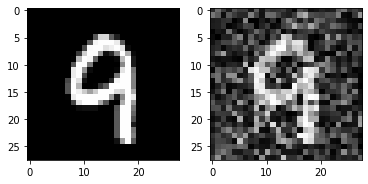

25  :  0.4910445668721683 25
50  :  0.4938244692369078 25
75  :  0.4937915428191674 25
100  :  0.49391714483543075 25
125  :  0.4937915428191674 25
150  :  0.4937915428191674 25
175  :  0.49395089741434545 25
200  :  0.4938495956780927 25
225  :  0.49393018839631014 25
250  :  0.493949490433297 25
275  :  0.4940678040243987 25
300  :  0.4941004006947601 25
325  :  0.49417953473056275 25
350  :  0.49422105058598487 25
375  :  0.49421388475282113 25
400  :  0.49422740411288046 25
425  :  0.49445557423166675 25
450  :  0.49445715547016184 25
475  :  0.4944540430534282 25
500  :  0.4944727561967145 25
525  :  0.494477924273113 25
550  :  0.49450026287216176 25
575  :  0.49454904963723717 25
600  :  0.4946585135528151 25
625  :  0.4946534757457168 25
650  :  0.494696479500543 25
675  :  0.49470938437420575 25
700  :  0.4946980861982011 25
725  :  0.4947194252907296 25
750  :  0.49476388250557524 25
775  :  0.49476388250557524 25
800  :  0.49477258079105213 25
Time:  34.853246450424194  seco

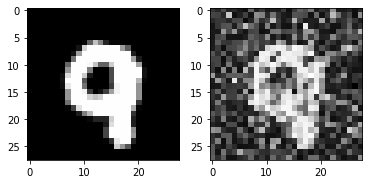

In [22]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28,28,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_cnn_mnist', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [24]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

56.72894477844238
33.917667627334595
36.12896591897995
2.8041051006777784


In [25]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1295
800
826.1507936507936
62.20856719699828


In [26]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

15.273933226489294
7.51499951062475
11.13042782529447
1.5309729667134773
